<img src="logo_UTN.svg" align="right" width="150" /> 

## Teoría de Circuitos II

### Trabajo Práctico 5

#### Por Grupo 2


# Ejercicio 1

Se desea digitalizar una señal cuyo espectro se muestra a continuación, trazado en azul.

![ej1_consigna](EJ1/img/ej1_consigna.JPG)

El rango de frecuencias de interés se centra entre DC y $10 kHz$, mientras que las frecuencias superiores a esta no aportan información.

Se sabe que el sistema digital introduce un ruido de densidad espectral constante, que se encuentra en $60 dB$ por debajo del nivel máximo de la señal.

Este ruido es consecuencia de los errores de cuantificación y del ruido propio de la electrónica del conversor, y no puede ser eliminado. El mismo está representado en el trazo rojo.

A partir de lo anterior, se pide:

A) Definir un valor para la frecuencia de muestreo $f_s$ del ADC, justificando su respuesta.

B) Diseñar un filtro analógico pasa bajo anti alias, esto es, que atenúe las componentes frecuenciales ubicadas por encima de la frecuencia de Nyquist, para evitar efecto alias. Explicar el criterio utilizado para fijar la atenuación en la banda detenida.

C) Repetir el punto b), pero eligiendo una $f_s$ diez veces más grande a la elegida en a). Comparar ambos filtros anti alias y evaluar las ventajas/desventajas de esta modificación.

D) Repetir el punto b), pero considerando que se requiere una fase aprox. lineal hasta $10 kHz$.


## Resolución

A) Para poder evitar el efecto del aliasing, deberíamos elegir una frecuencia de muestreo que sea al menos 2 veces mayor que la máxima frecuencia de interés. Considerando que nuestro rango de interés llega hasta los $10 KHz$, deberíamos elegir:

$f_s \geq 2 . f_{max}$

$f_s \geq 20KHz$

Seleccionamos una $f_s = 30KHz$ para tener un margen en el sistema y no estar en la condición crítica.

B) La señal que se quiere digitalizar, en $f=10KHz$ se encuentra $40dB$ por debajo de su valor de potencia máximo. Considerando que el piso de ruido digital se encuentra en $-60dB$, deberíamos diseñar un filtro que tenga una atenuación mínima de $20dB$ para todas las frecuencias superiores a $f_{nyq} = \frac{f_s}{2} = 15KHz$.

Teniendo esto en consideración podemos plantear la siguiente plantilla:

<div><img src="EJ1/img/ej1_plantilla_desnormalizada.jpeg" width="500"/></div>

Al normalizarla queda:

<div><img src="EJ1/img/ej1_plantilla_normalizada.jpeg" width="500"/></div>

Se puede preveer que requeriremos un rolloff "rápido", por lo cual planteamos una aproximación de Chebyshev:

$|T(j\omega)| = \frac{1}{1+\varepsilon^2.C_n^2}$

Utilizamos python para averiguar $\varepsilon$ y el orden $n$ del filtro.

In [2]:
import numpy as np

ws = 1.5
ee = 10**(1/10)-1
print(f'ee: {ee}')

for n in range(1,6):
    Cn = np.cosh(n*np.arccosh(ws))
    alpha = 10*np.log10(1+ee*Cn**2)
    print(f'alpha(n = {n}) = {alpha}')


ee: 0.2589254117941673
alpha(n = 1) = 1.993662702785931
alpha(n = 2) = 6.203272580959268
alpha(n = 3) = 13.418885326100998
alpha(n = 4) = 21.583370328355812
alpha(n = 5) = 29.913681459660868


A partir de $n=4$ se cumple con el requerimiento de atenuación mínima, por lo que nos quedamos con este orden.

La función de aproximación queda:

$|T(j\omega)|^2 = \frac{1}{1+\varepsilon^2.C_4^2}$

Donde $C_4$ tiene la forma:

$C_4 = 8.\omega^4-8.\omega^2+1$

$|T(j\omega)|^2 = \frac{1}{1+\varepsilon^2.(8.\omega^4-8.\omega^2+1)^2}$

$|T(j\omega)|^2 = \frac{1}{1+\varepsilon^2.(64.\omega^8-128.\omega^6+80.\omega^4-16.\omega^2+1)}$

$|T(s)|^2 = \frac{1}{1+\varepsilon^2.(64.s^8+128.s^6+80.s^4+16.s^2+1)}$

$|T(s)|^2 = \frac{1}{\varepsilon^2.64.s^8+\varepsilon^2.128.s^6+\varepsilon^2.80.s^4+\varepsilon^2.16.s^2+(\varepsilon^2+1)}$

Utilizamos python para hallar los polos.

In [3]:
den = [ee*64, ee*0, ee*128, ee*0, ee*80, ee*0, ee*16, ee*0, ee+1]

raices = np.roots(den)

for raiz in raices:
    if np.real(raiz) < 0:
        print(raiz)

(-0.1395359959054355+0.9833791644951989j)
(-0.1395359959054355-0.9833791644951989j)
(-0.3368696937541342+0.4073289868890343j)
(-0.3368696937541342-0.4073289868890343j)


Una vez obtenidos los polos, se puede plantear la transferencia del filtro como 2 secciones de 2do orden:

$T(s) = \frac{1}{s^2+s.0,279+0,9863} . \frac{1}{s^2+s.0,6736+0,2793} . \frac{1}{\sqrt{\varepsilon^2.64}}$

In [4]:
import matplotlib.pyplot as plt
import scipy.signal as sig
from splane import analyze_sys

num = [0.2456]
den = [1, 0.9526, 1.4535, 0.7422, 0.2754]
%matplotlib qt
transfer_f = sig.TransferFunction(num, den)

plt.close('all')
analyze_sys(transfer_f, 'Transferencia')

Estas secciones de 2do orden se pueden implementar con el siguiente circuito:

![circuito](EJ1/img/ej1_circuito.JPG)

Al simularlo, podemos verificar la transferencia:

![transferencia](EJ1/img/ej1_transferencia.JPG)

![cursores](EJ1/img/ej1_cursores.JPG)

Se puede apreciar que cerca de la frecuencia máxima de interés ($10KHz$) tiene una atenuación de prácticamente $1dB$ y para frecuencias mayores a la frecuencia de Nyquist ($15KHz$) la atenuación supera los $20dB$.

In [5]:
# Desnormalización de los componentes

Wz = 1000
Ww = 2*np.pi*10000

C1a_n = 5.068
C1b_n = 0.2995
R1_n = 1
L1_n = 3.5842
C2a_n = 43.21
C2b_n = 2.5539
R2_n = 1
L2_n = 1.4845

C1a_dn = C1a_n / (Ww*Wz)
C1b_dn = C1b_n / (Ww*Wz)
R1_dn = R1_n * Wz
L1_dn = L1_n * Wz / Ww
C2a_dn = C2a_n / (Ww*Wz)
C2b_dn = C2b_n / (Ww*Wz)
R2_dn = R2_n * Wz
L2_dn = L2_n * Wz / Ww

print(f'C1a_dn: {C1a_dn}')
print(f'C1b_dn: {C1b_dn}')
print(f'R1_dn: {R1_dn}')
print(f'L1_dn: {L1_dn}')
print(f'C2a_dn: {C2a_dn}')
print(f'C2b_dn: {C2b_dn}')
print(f'R2_dn: {R2_dn}')
print(f'L2_dn: {L2_dn}')


C1a_dn: 8.065972515897255e-08
C1b_dn: 4.766690545602265e-09
R1_dn: 1000
L1_dn: 0.05704431470299713
C2a_dn: 6.877085091000797e-07
C2b_dn: 4.064658091623915e-08
R2_dn: 1000
L2_dn: 0.023626551301991865


C) Al elegir una frecuencia de sampling 10 veces mayor, nos quedaría que: $f_s=300KHz$ y $f_{nyq} = 150KHz$

Por lo tanto, en la plantilla normalizada, la $\omega_s$ se hallaría en $15$

In [7]:
ws = 15
ee = 10**(1/10)-1
print(f'ee: {ee}')

for n in range(1,4):
    Cn = np.cosh(n*np.arccosh(ws))
    alpha = 10*np.log10(1+ee*Cn**2)
    print(f'alpha(n = {n}) = {alpha}')

ee: 0.2589254117941673
alpha(n = 1) = 17.72748584794907
alpha(n = 2) = 47.176756774247565
alpha(n = 3) = 76.70942089084363


Ahora basta con un orden 2 para cumplir con el requerimiento de $\alpha_{min}$ en $\omega_s$

La función de aproximación queda:

$|T(j\omega)|^2 = \frac{1}{1+\varepsilon^2.C_2^2}$

Donde $C_2$ tiene la forma:

$C_ = 2.\omega^2-1$

$|T(j\omega)|^2 = \frac{1}{1+\varepsilon^2.(2.\omega^2-1)^2}$

$|T(j\omega)|^2 = \frac{1}{1+\varepsilon^2.(4.\omega^4-4.\omega^2+1)}$

$|T(s)|^2 = \frac{1}{1+\varepsilon^2.(4.s^4+4.s^2+1)}$

$|T(s)|^2 = \frac{1}{\varepsilon^2.4.s^4+\varepsilon^2.4.s^2+(1+\varepsilon^2.)}$

Utilizamos Python para hallar los polos:

In [9]:
den = [ee*4, 0, ee*4, 0, (1+ee)]

raices = np.roots(den)

for raiz in raices:
    if np.real(raiz) < 0:
        print(raiz)

(-0.5488671642819637+0.8951285740199127j)
(-0.5488671642819637-0.8951285740199127j)


Una vez obtenidos los polos, se puede plantear la transferencia del filtro:

$T(s) = \frac{1}{s^2+s.1,0976+1.1023}.\frac{1}{\sqrt{\varepsilon^2.4}}$

In [10]:
num = [0.9826]
den = [1, 1.0976, 1.1023]
%matplotlib qt
transfer_f = sig.TransferFunction(num, den)

plt.close('all')
analyze_sys(transfer_f, 'Transferencia')

Este sistema de segundo orden puede implementarse con el siguiente circuito:

![circuito_2](EJ1/img/ej1_circuito_2.JPG)

Que presenta la siguiente transferencia:

![transferencia_2](EJ1/img/ej1_transferencia_2.JPG)

![cursores_2](EJ1/img/ej1_cursores_2.JPG)

Se puede observar que los $20dB$ de atenuación no se encuentran en $f_{nyq}$, pero tampoco están tan cerca de la frecuencia máxima de interés como en el caso anterior.

La principal ventaja de este filtro es que es más simple que el anterior ya que es de menor orden. La desventaja que presenta tiene que ver con que cualquier valor de la señal que exista entre $10KHz$ y $33.65KHz$ donde se encuentra la atenuación de $20dB$ interferirá con nuestra señal ya que no estará del todo atenuada.

In [11]:
# Desnormalización de los componentes

Wz = 1000
Ww = 2*np.pi*10000

R_n = 1
L_n = 0.911
Ca_n = 57.22
Cb_n = 1.0133

R_dn = R_n * Wz
L_dn = (L_n * Wz) / Ww
Ca_dn = Ca_n / (Wz * Ww)
Cb_dn = Cb_n / (Wz * Ww)

print(f'R_dn: {R_dn}')
print(f'L_dn: {L_dn}')
print(f'Ca_dn: {Ca_dn}')
print(f'Cb_dn: {Cb_dn}')

R_dn: 1000
L_dn: 0.014499015315671665
Ca_dn: 9.106845843718251e-07
Cb_dn: 1.6127170383501754e-08


# Ejercicio 2

![Consigna](EJ2/Consigna1.png "Consigna")

## Desarrollo

![1](EJ2/Desarrollo/1.jpeg "1")

## Simulación

In [28]:
# Módulos para Jupyter

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
#%%  Inicialización de librerías
# Setup inline graphics: Esto lo hacemos para que el tamaño de la salida, 
# sea un poco más adecuada al tamaño del documento
mpl.rcParams['figure.figsize'] = (25,15)

#%% Esto tiene que ver con cuestiones de presentación de los gráficos,
# NO ES IMPORTANTE
fig_sz_x = 14
fig_sz_y = 13
fig_dpi = 80 # dpi

#fig_font_family = 'Ubuntu'
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})
#plt.rcParams.update({'font.family':fig_font_family})

# módulo de SciPy
from scipy import signal as sig

# un módulo adaptado a mis necesidades
from splane import analyze_sys, pretty_print_bicuad_omegayq

In [31]:
def print_analog_digital(w_z, H_z, fs, w_s, H_s):
    plt.close('all')
    fig, ax = plt.subplots(2,1)
    ax[0].set_title('Respuesta de modulo') 
    ax[0].semilogx(w_z*fs, 20 * np.log10(abs(H_z)), 'b--', w_s, 20 * np.log10(abs(H_s)), 'g-') 
    ax[0].set_ylabel('Amplitud [dB]') 
    ax[0].set_xlabel('Frecuencia [rad/seg]') 
    ax[0].grid(True) 
    ax[0].legend(['H(z)', 'H(s)']) 
    ax[0].set_xlim([1, 1e6]) 
    ax[0].set_ylim([-160, 10]) 
    angles_z = np.unwrap(np.angle(H_z)) 
    angles_s = np.unwrap(np.angle(H_s)) 
    ax[1].set_title('Respuesta de fase') 
    ax[1].semilogx(w_z*fs, angles_z, 'b--', w_s, angles_s, 'g') 
    ax[1].set_ylabel('Angulo (radianes)') 
    ax[1].grid(True)
    ax[1].legend(['H(z)', 'H(s)']) 
    ax[1].set_xlim([1, 1e6]) 
    ax[1].set_ylim([-3.5, 0]) 

#### $f_c=1KHz\;\;\;\;\;f_s=100KHz$

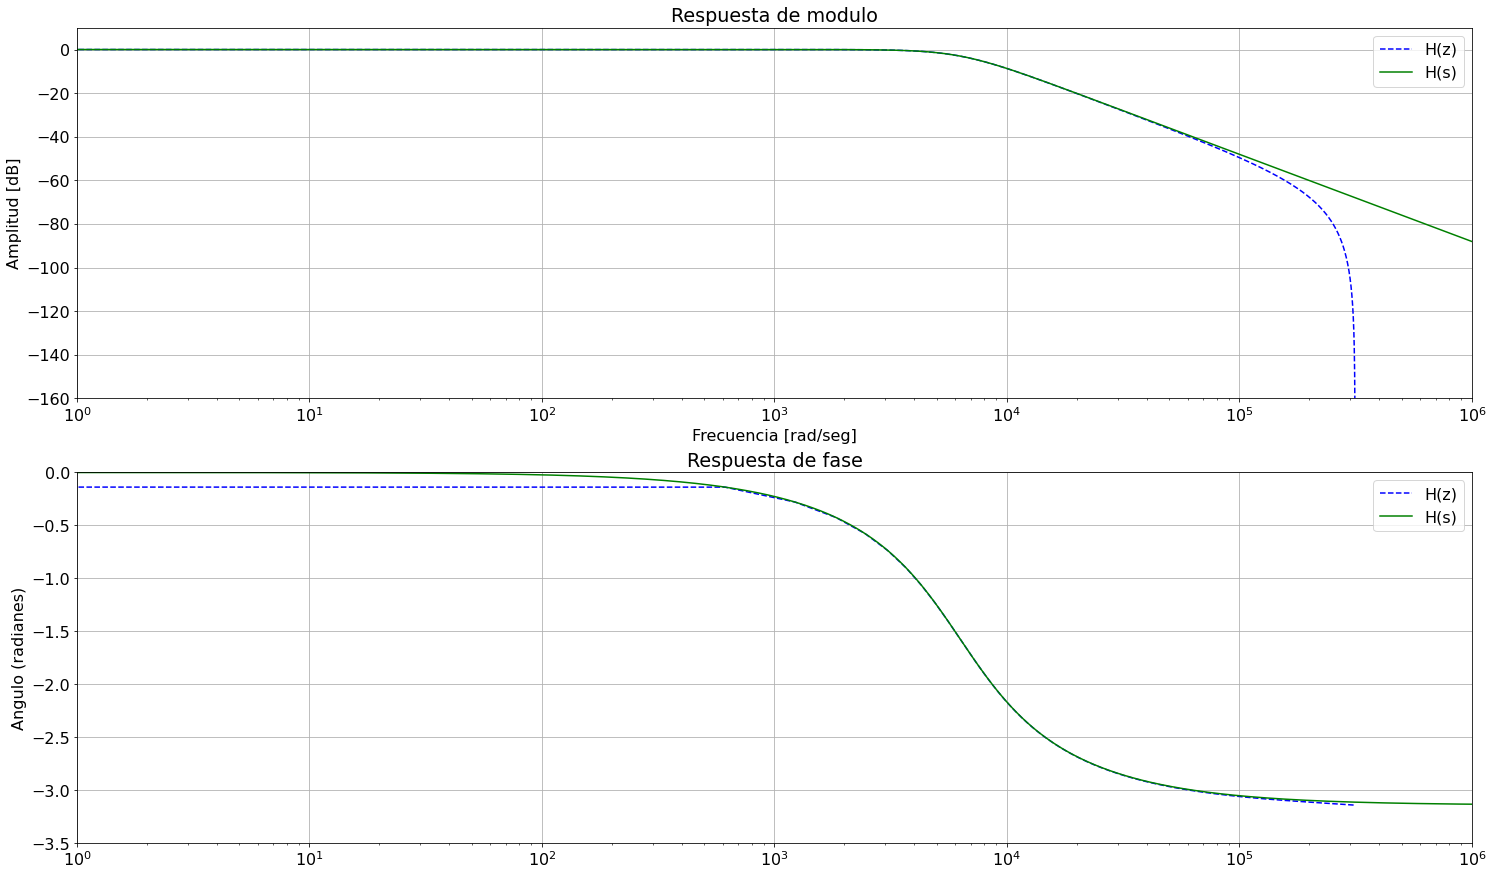

In [8]:
fc = 1e3
wo = 2*np.pi*fc
num1 = np.array([wo**2])
den1 = np.array([1, np.sqrt(2)*wo, wo**2])

# Módulo y fase analógica
w_s, H_s = sig.freqs(num1, den1, worN = np.logspace(-1,7,1000))

# Módulo y fase digital
fs1 = 100e3
num1_z, den1_z = sig.bilinear(num1, den1, fs = fs1)
w_z, H_z = sig.freqz(num1_z, den1_z)

# Ploteo analógica y digital
print_analog_digital(w_z, H_z, fs1, w_s, H_s)

#### $f_c=1KHz\;\;\;\;\;f_s=10KHz$

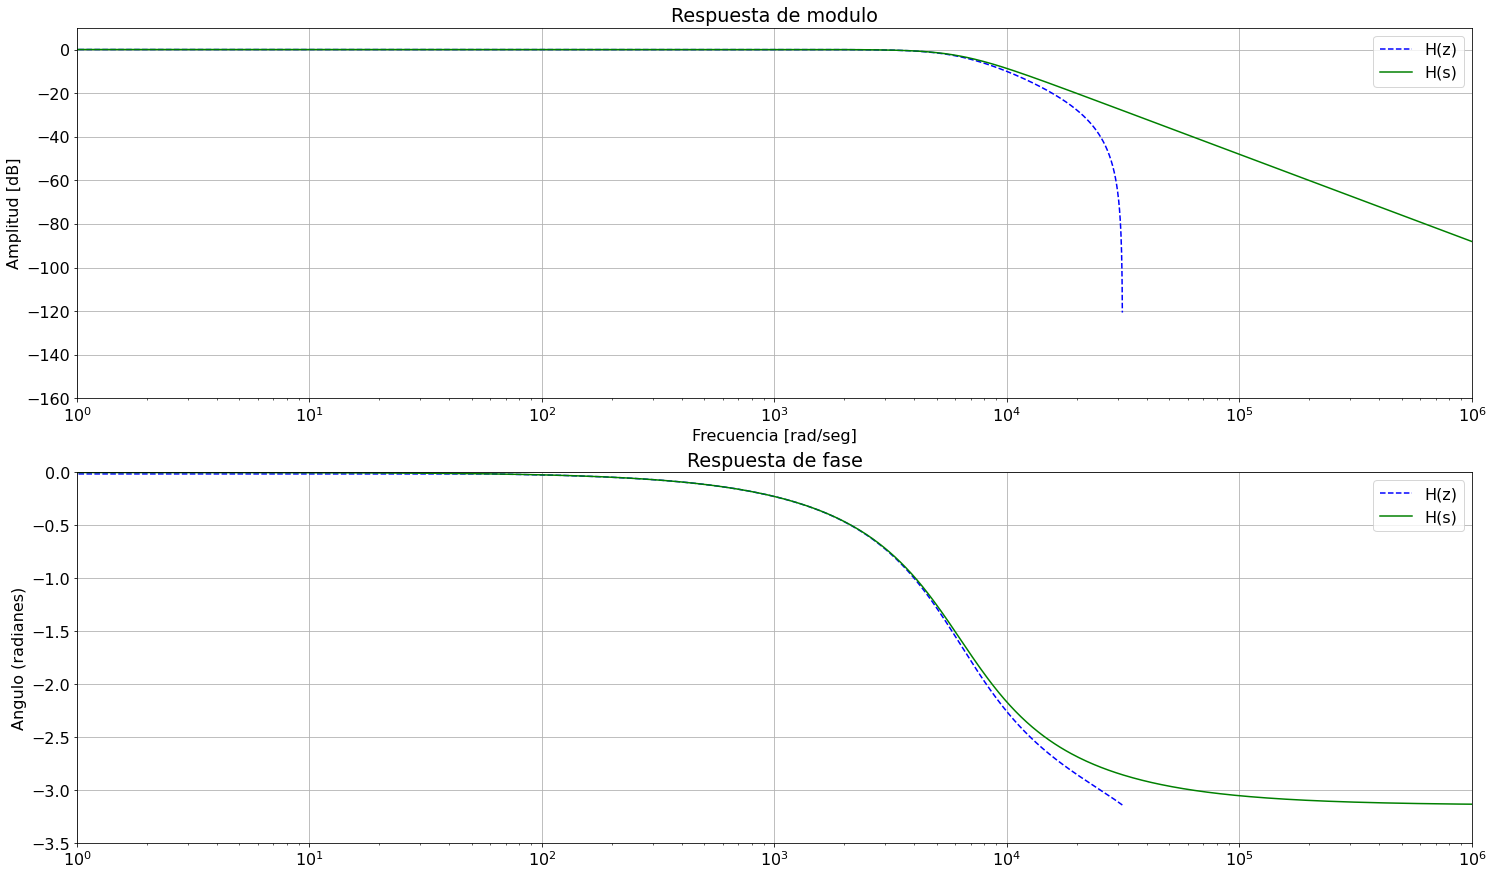

In [9]:
fc = 1e3
wo = 2*np.pi*fc
num1 = np.array([wo**2])
den1 = np.array([1, np.sqrt(2)*wo, wo**2])

# Módulo y fase analógica
w_s, H_s = sig.freqs(num1, den1, worN = np.logspace(-1,7,1000))

# Módulo y fase digital
fs1 = 10e3
num1_z, den1_z = sig.bilinear(num1, den1, fs = fs1)
w_z, H_z = sig.freqz(num1_z, den1_z)

# Ploteo analógica y digital
print_analog_digital(w_z, H_z, fs1, w_s, H_s)

#### $f_c=6KHz\;\;\;\;\;f_s=100KHz$

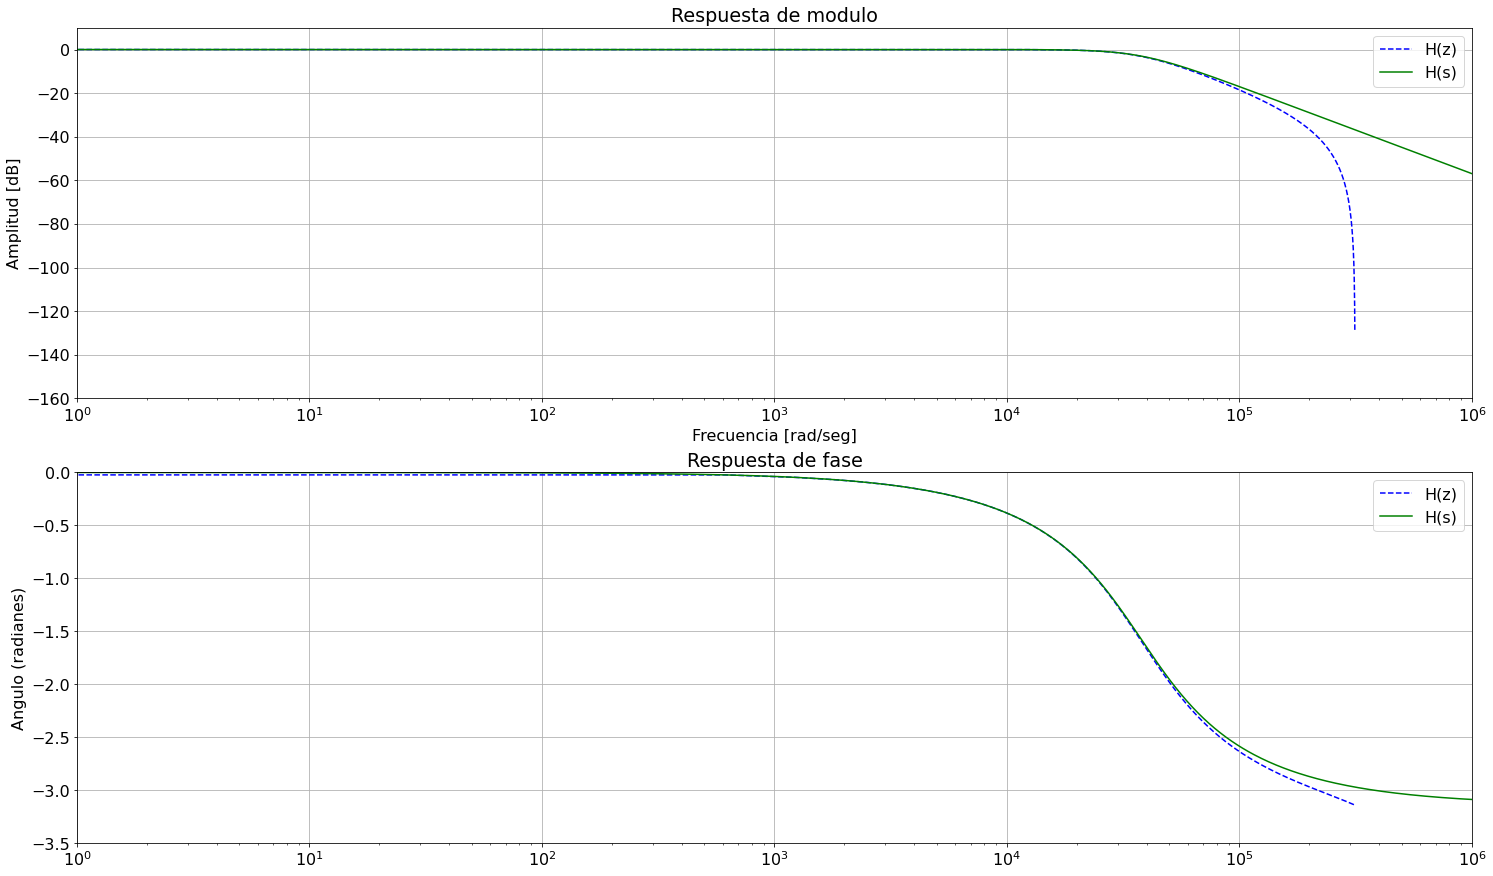

In [10]:
fc = 6e3
wo = 2*np.pi*fc
num1 = np.array([wo**2])
den1 = np.array([1, np.sqrt(2)*wo, wo**2])

# Módulo y fase analógica
w_s, H_s = sig.freqs(num1, den1, worN = np.logspace(-1,7,1000))

# Módulo y fase digital
fs1 = 100e3
num1_z, den1_z = sig.bilinear(num1, den1, fs = fs1)
w_z, H_z = sig.freqz(num1_z, den1_z)

# Ploteo analógica y digital
print_analog_digital(w_z, H_z, fs1, w_s, H_s)

#### $f_c=6KHz\;\;\;\;\;f_s=10KHz$

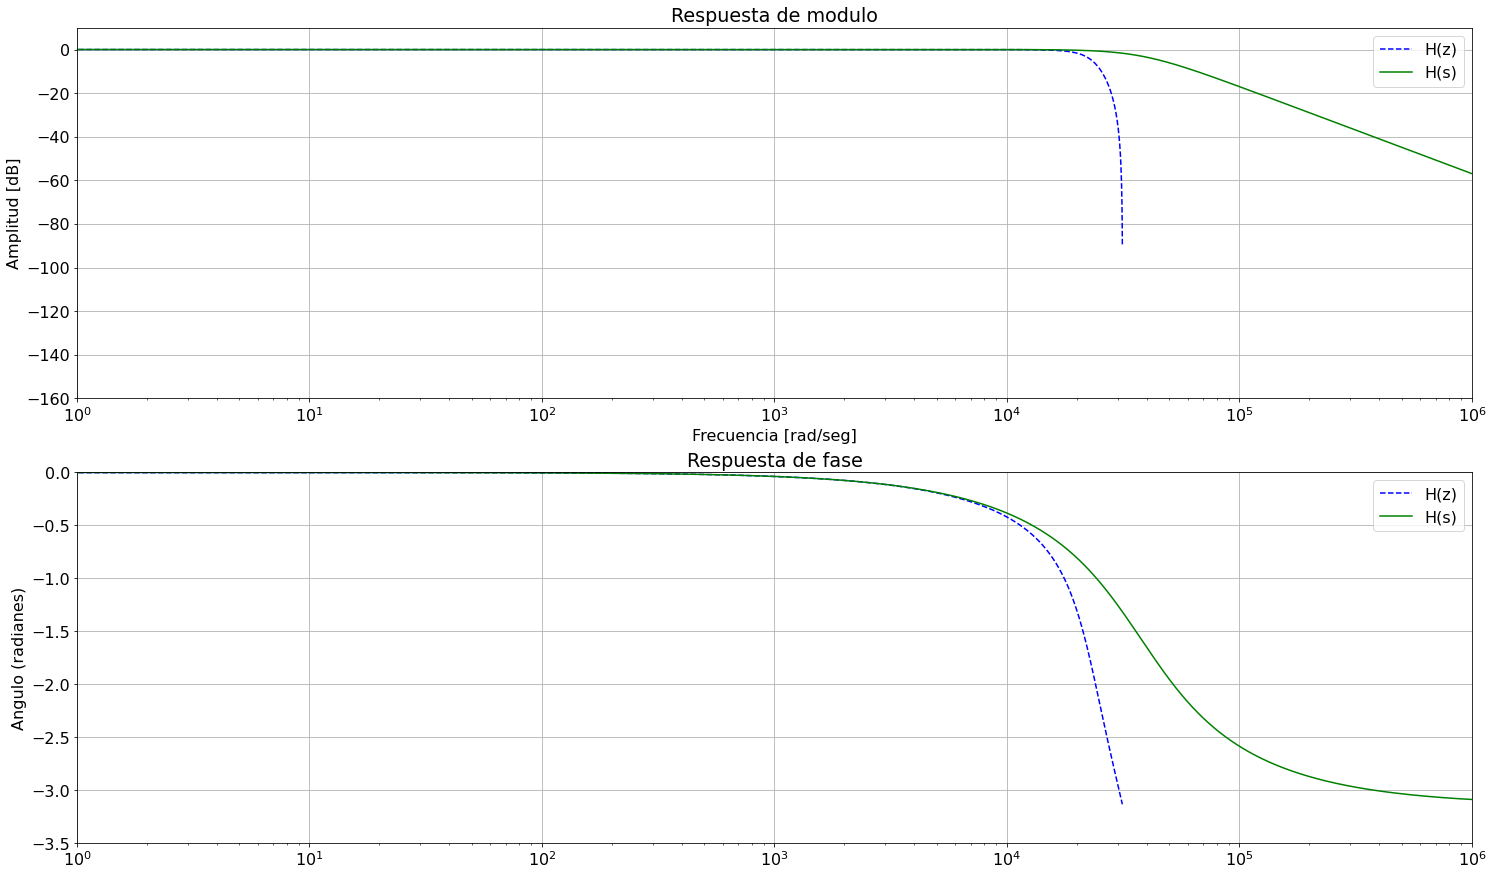

In [11]:
fc = 6e3
wo = 2*np.pi*fc
num1 = np.array([wo**2])
den1 = np.array([1, np.sqrt(2)*wo, wo**2])

# Módulo y fase analógica
w_s, H_s = sig.freqs(num1, den1, worN = np.logspace(-1,7,1000))

# Módulo y fase digital
fs1 = 10e3
num1_z, den1_z = sig.bilinear(num1, den1, fs = fs1)
w_z, H_z = sig.freqz(num1_z, den1_z)

# Ploteo analógica y digital
print_analog_digital(w_z, H_z, fs1, w_s, H_s)

Se podría aplicar prewarping en el caso de $f_c=6KHz\;\; y \;\;f_s=10KHz$, ya que aquí en el caso digital se obtienen los -3db antes de la frecuencia establecida, pudiendo corregir a ese punto.

# Ejercicio 3

![Consigna](EJ3/Consigna1.png "Consigna")

![Consigna](EJ3/Consigna2.png "Consigna")

## Desarrollo

![1](EJ3/Desarrollo/1.jpeg "1")

Para que la salida represente la media aritmética, debería dividirse cada muestra de salida por el total de muestras de la entrada utilizadas para el promedio. Y como el filtro de media móvil tiene una naturaleza pasabajos, elimina completamente la frecuencia en pi o fs/2, por lo que si quiero eliminar la frecuencia de linea de 50Hz debería colocar 100 Hz de Fs.

![2](EJ3/Desarrollo/2.jpeg "2")

Ambos sistemas introducen una demora de media muestra, esto no es deseado ya que genera una incertidumbre sobre la muestra siguiente, pudiendo ser 1 muestra o ninguna. La respuesta de módulo de un derivador es una función lineal, por lo que consideraremos las funciones dadas ideales hasta cierta frecuencia con la tolerancia presentada. El segundo sistema se comporta como un derivador ideal hasta Omega = 0.5515, pero presenta la ventaja de atenuar las altas frecuencias, disminuyendo así en una señal de baja frecuencia la inferencia del ruido en la diferencia. El primer sistema, deja pasar más facilmente las muestras de alta frecuencia que en el rango que se comporta como un derivador (parte lineal).

# Ejercicio 4

![Consigna](EJ4/Consignas/Consigna.png "Consigna")

## Punto A

![Consigna](EJ4/Consignas/ConsignaA1.png "Consigna")

![Consigna](EJ4/Consignas/ConsignaA2.png "Consigna")

$X_1(z) = X(z) - X(z).c_1.Z^{-N}$

#### Biquad direct form 2
$X_3(z) = X_2(z).a_0$

$Y(z) = X_2(z).a_0.b_0 + X_2(z).a_0.z^{-1}.b_1 + X_2(z).a_0.z^{-2}.b_2$

Donde:

$X_2(z) = X_1(z) + X_2(z).a_0.z^{-1}.a_1 + X_2(z).a_0.z^{-2}.a_2$

$X_2(z).(-z^{-2}.a_2.a_0 - z^{-1}.a_1.a_0 + 1) = X_1(z)$

$X_2(z) = X_1(z).\frac{1}{(-z^{-2}.a_2.a_0 - z^{-1}.a_1.a_0 + 1)}$

Entonces:

$Y(z) =  X_2(z) . (z^{-2}.b_2.a_0 + z^{-1}.b_1.a_0 + b_0.a_0)$

$Y(z) =  X_1(z).\frac{1}{(-z^{-2}.a_2.a_0 - z^{-1}.a_1.a_0 + 1)} . (z^{-2}.b_2.a_0 + z^{-1}.b_1.a_0 + b_0.a_0)$

$Y(z) =  (X(z) - X(z).c_1.Z^{-N}).\frac{(z^{-2}.b_2.a_0 + z^{-1}.b_1.a_0 + b_0.a_0)}{(-z^{-2}.a_2.a_0 - z^{-1}.a_1.a_0 + 1)}$

$H(z) = \frac{Y(z)}{X(z)}  =  (1 - c_1.Z^{-N}).\frac{b_0 + z^{-1}.b_1 + z^{-2}.b_2}{1/a_0 - z^{-1}.a_1 - z^{-2}.a_2 }$

## Simulación

In [6]:
# Módulos para Jupyter

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
#%%  Inicialización de librerías
# Setup inline graphics: Esto lo hacemos para que el tamaño de la salida, 
# sea un poco más adecuada al tamaño del documento
mpl.rcParams['figure.figsize'] = (25,15)

#%% Esto tiene que ver con cuestiones de presentación de los gráficos,
# NO ES IMPORTANTE
fig_sz_x = 14
fig_sz_y = 13
fig_dpi = 80 # dpi

#fig_font_family = 'Ubuntu'
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})
#plt.rcParams.update({'font.family':fig_font_family})

# módulo de SciPy
from scipy import signal as sig

# un módulo adaptado a mis necesidades
from splane import analyze_sys, pretty_print_bicuad_omegayq

In [21]:
def group_delay(ww, phase):
    
    groupDelay = -np.diff(phase)/np.diff(ww)
    
    return(np.append(groupDelay, groupDelay[-1]))

In [23]:
def print_digital(w_z, H_z, label):
    plt.close('all')
    # Modulo
    plt.title('Respuesta de modulo')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Módulo [dB]')
    plt.plot(w_z, 20 * np.log10(np.abs(H_z)), label=label)

    # Fase
    plt.figure()
    plt.title('Respuesta de fase')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Ángulo [rad]')
    fase = np.unwrap(np.angle(H_z))
    plt.plot(w_z, fase, label=label)
    plt.grid(which='both', axis='both')

    # Retardo
    gd_iir = group_delay(w_z, fase)
    plt.figure()
    plt.title('Retardo de grupo IIR')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Demora [s]')
    plt.plot(w_z, gd_iir, label=label)
    plt.grid(which='both', axis='both')

## Punto B

![Consigna](EJ4/Consignas/ConsignaB.png "Consigna")

#### · N = 3
$H(z) = \frac{1}{3}.\frac{1-z^{-3}}{1-z^{-1}}.\frac{z^{3}}{z^{3}}$

$H(z) = \frac{1}{3}.\frac{z^{3} - 1}{z^{3}-z^{2}}$

#### · N = 4
$H(z) = \frac{1}{4}.\frac{1-z^{-4}}{1-z^{-1}}.\frac{z^{4}}{z^{4}}$

$H(z) = \frac{1}{4}.\frac{z^{4} - 1}{z^{4}-z^{3}}$

#### · N = 5
$H(z) = \frac{1}{5}.\frac{1-z^{-5}}{1-z^{-1}}.\frac{z^{5}}{z^{5}}$

$H(z) = \frac{1}{5}.\frac{z^{5} - 1}{z^{5}-z^{4}}$


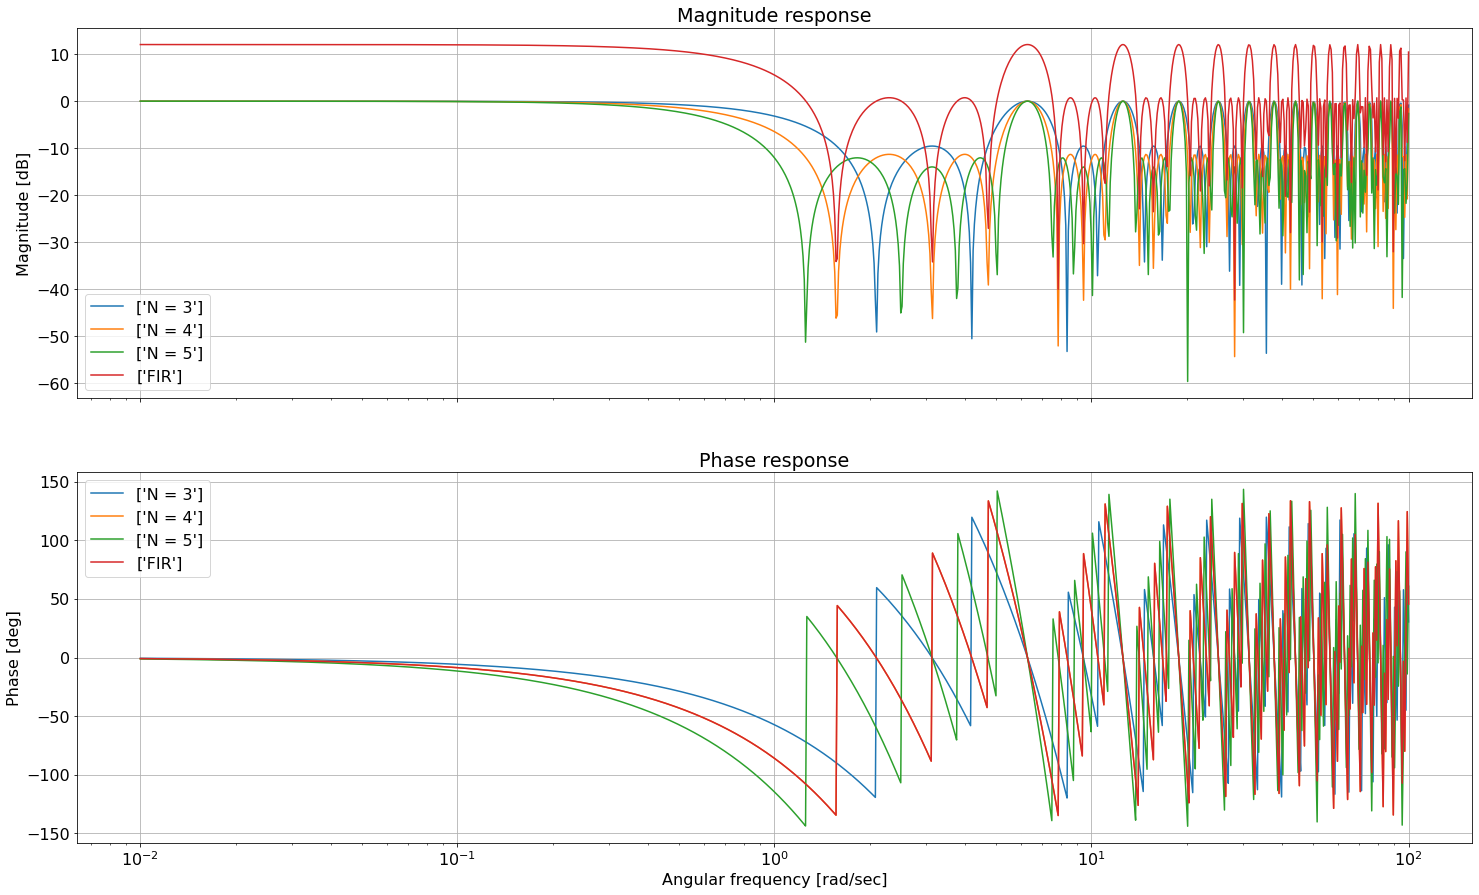

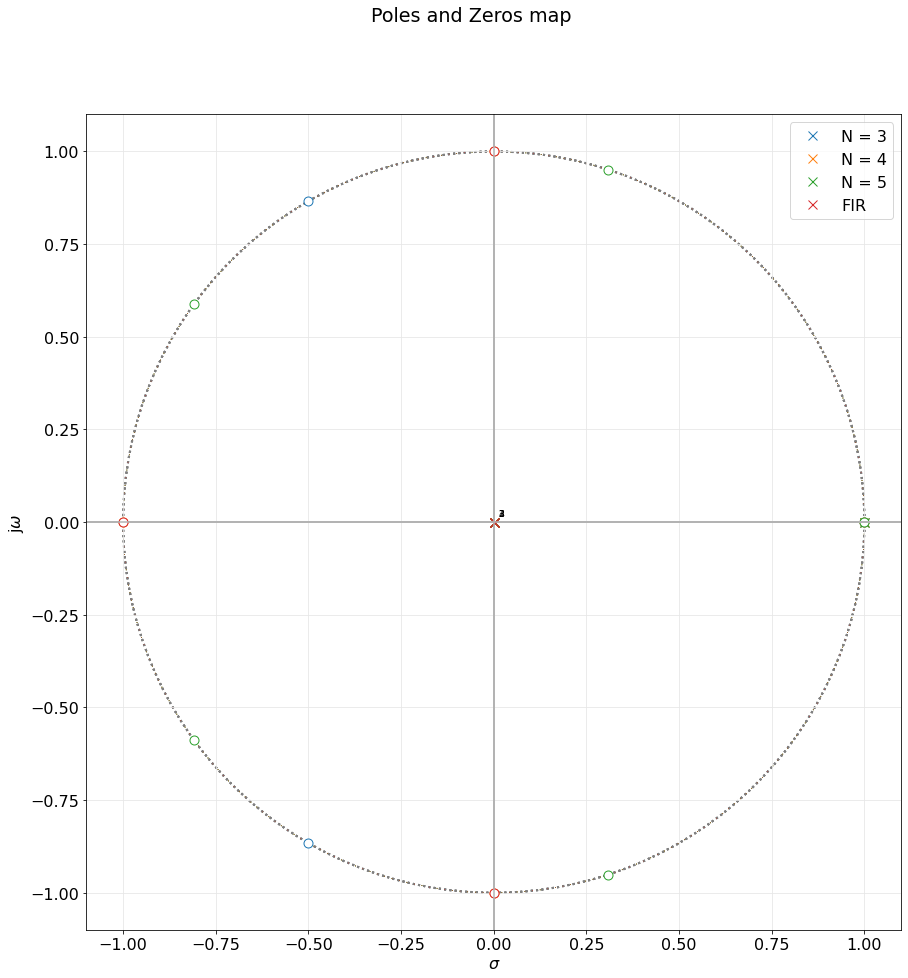

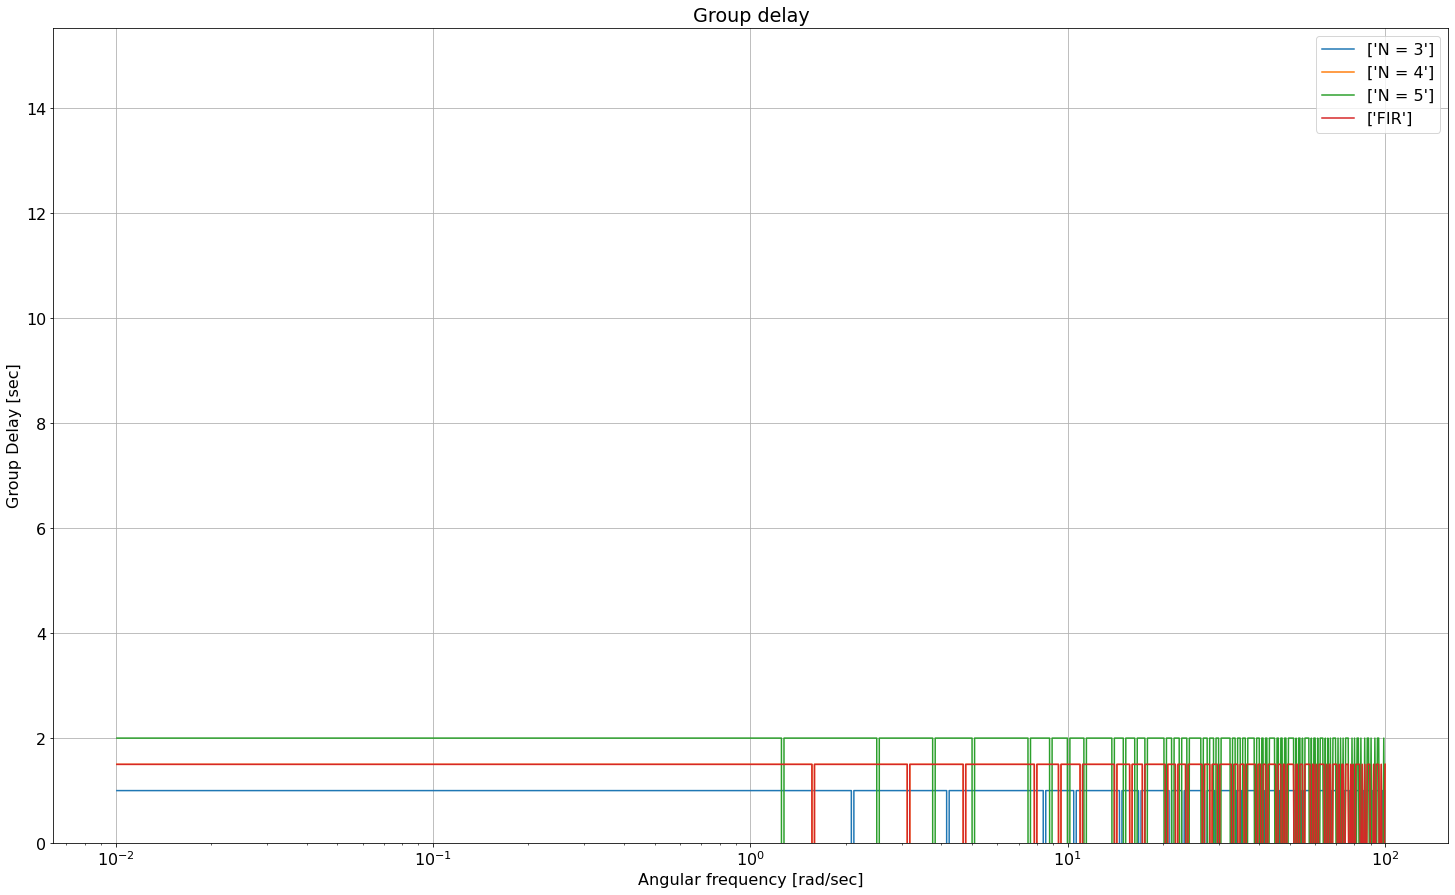

In [58]:
# Coeficientes en potencias decreciente
num_3 = (1/3)*np.array([1, 0, 0, -1])
den_3 = np.array([1, -1, 0, 0])

num_4 = (1/4)*np.array([1, 0, 0, 0, -1])
den_4 = np.array([1, -1, 0, 0, 0])

num_5 = (1/5)*np.array([1, 0, 0, 0, 0, -1])
den_5 = np.array([1, -1, 0, 0, 0, 0])

num_fir = np.array([1, 1, 1, 1])
den_fir = np.array([1, 0, 0, 0])

# Módulo y fase
sos_n3 = sig.TransferFunction(num_3, den_3, dt = 1)
sos_n4 = sig.TransferFunction(num_4, den_4, dt = 1)
sos_n5 = sig.TransferFunction(num_5, den_5, dt = 1)
sos_fir = sig.TransferFunction(num_fir, den_fir, dt = 1)

#all_sos = [sos_n4, sos_fir]
#analyze_sys(all_sos, sys_name=['N = 4', 'FIR'])
all_sos = [sos_n3, sos_n4, sos_n5, sos_fir]
analyze_sys(all_sos, sys_name=['N = 3', 'N = 4', 'N = 5', 'FIR'])

### 1)
Es un filtro IIR, ya que tiene terminos $a_i$ no nulos, por lo que será recursivo. Si bien emula el comportamiento de un filtro FIR al tener retardo constante, en su implementación es un filtro IIR.

### 2)
Respecto al FIR de media movil, se puede ver que este sistema no presenta ningún factor de escala, aprovechando al máximo la atenuación lograda, al contrario del primero mencionado.

### 3)
Podría implementarse $h_6(k) = (1,1,1,1,1,1,1)$ con N = 7, ya que este sistema logra emular a un FIR por la localización de los polos y ceros:

FIR media movil N = 6:
$H(z) = \frac{z^{6} + z^{5} + z^{4} + z^{3} + z^{2} + z^{1} + 1}{z^{6}}$

##### N = 7
$H(z) = \frac{1}{7}.\frac{1-z^{-7}}{1-z^{-1}}.\frac{z^{7}}{z^{7}}$

$H(z) = \frac{1}{7}.\frac{z^{7} - 1}{z^{7}-z^{6}}$

## Punto C

![Consigna](EJ4/Consignas/ConsignaC.png "Consigna")

#### Diferenciador de primer orden
$h(k) = (1,-1)$

$H(z) = 1-z^{-1} = \frac{z-1}{z}$

$H(z) = \frac{Y(z)}{X(z)}  =  (1 - c_1.Z^{-N}).\frac{b_0 + z^{-1}.b_1 + z^{-2}.b_2}{1/a_0 - z^{-1}.a_1 - z^{-2}.a_2 }$

$c_1=0, b_0=1, b_1=-1, b_2=0, a_0=1, a_1=0, a_2=0$




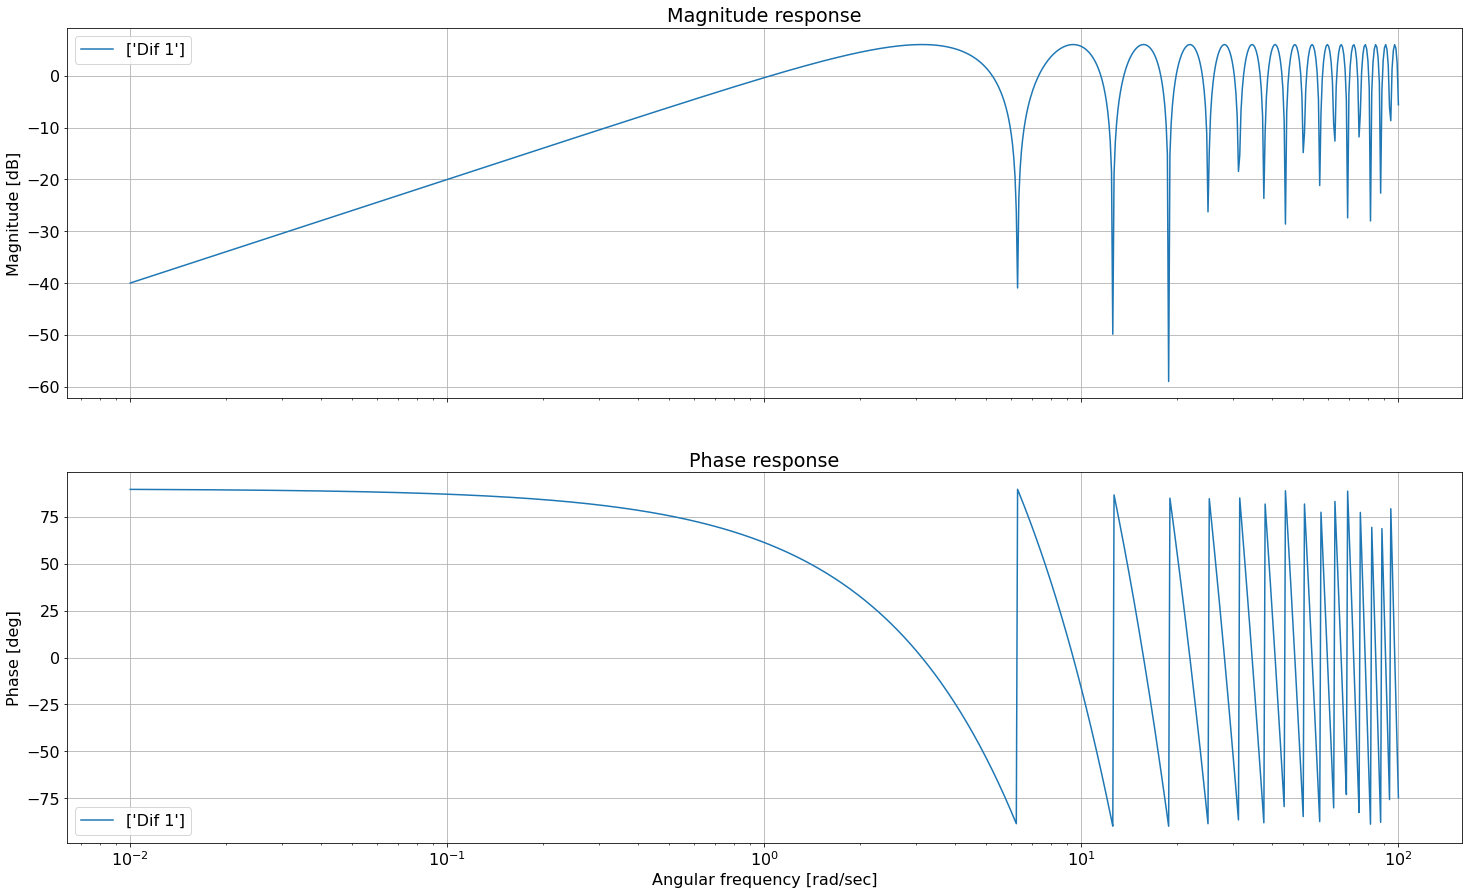

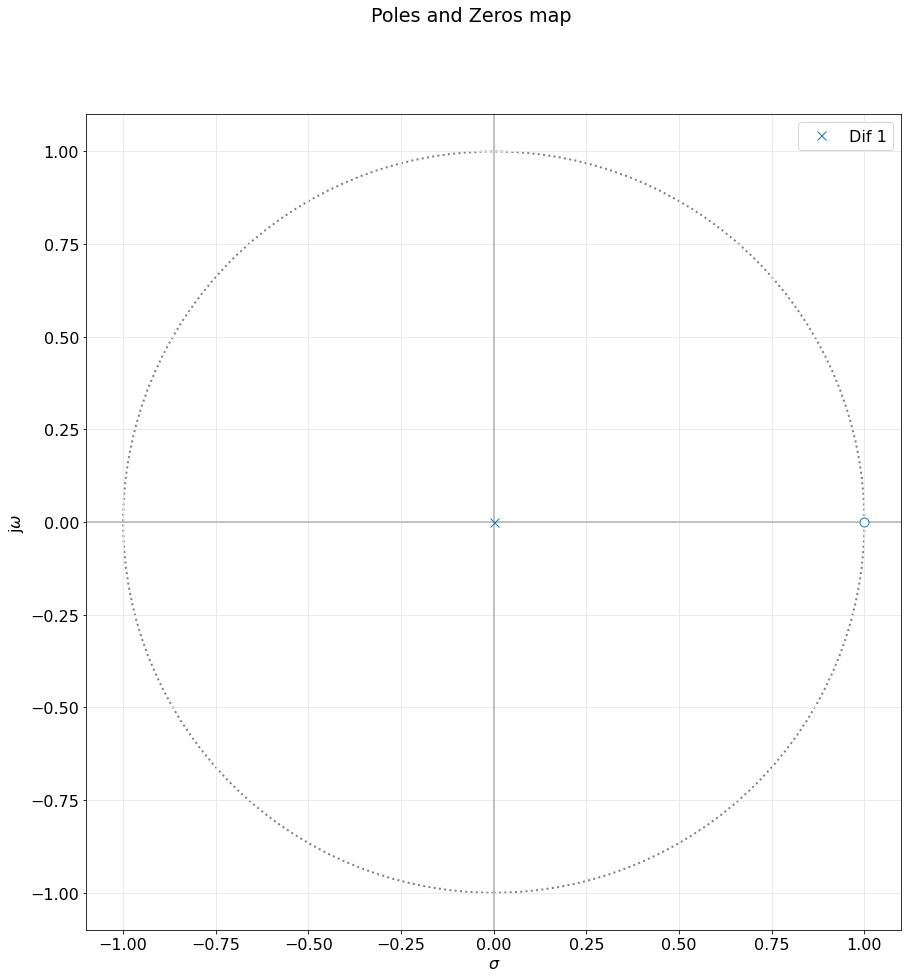

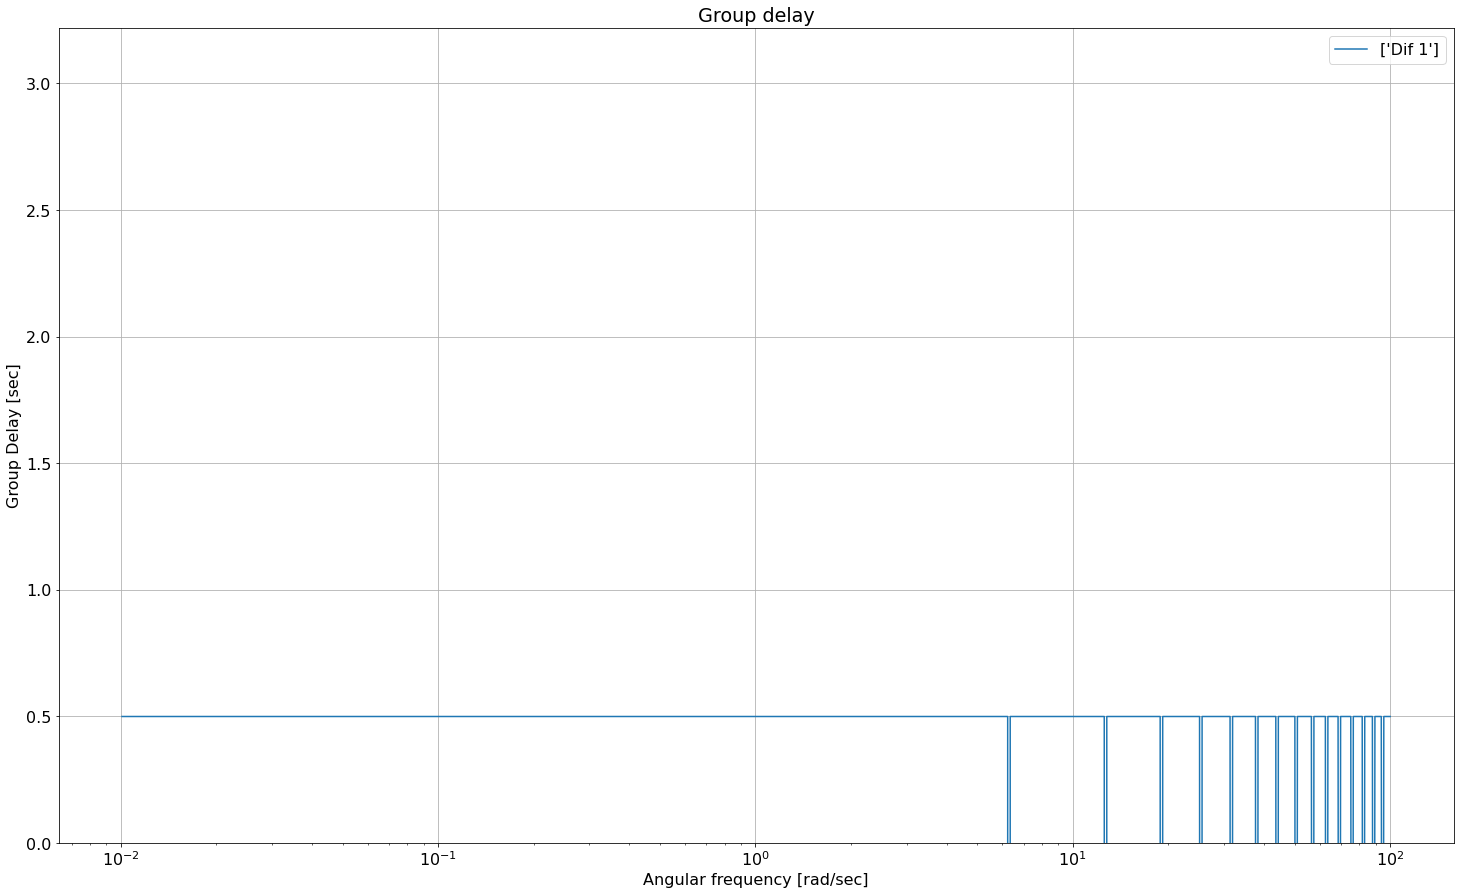

In [52]:
# Coeficientes en potencias decreciente
num_dif_1 = np.array([1, -1])
den_dif_1 = np.array([1, 0])

# Módulo y fase
sos_dif_1 = sig.TransferFunction(num_dif_1, den_dif_1, dt = 1)

all_sos = [sos_dif_1]
analyze_sys(all_sos, sys_name=['Dif 1'])

#### Diferenciador de segundo orden
$h(k) = (1,0,-1)$

$H(z) = 1-z^{-2} = \frac{z^{2}-1}{z^{2}}$

$H(z) = \frac{Y(z)}{X(z)}  =  (1 - c_1.Z^{-N}).\frac{b_0 + z^{-1}.b_1 + z^{-2}.b_2}{1/a_0 - z^{-1}.a_1 - z^{-2}.a_2 }$

$c_1=0, b_0=1, b_1=0, b_2=-1, a_0=1, a_1=0, a_2=0$




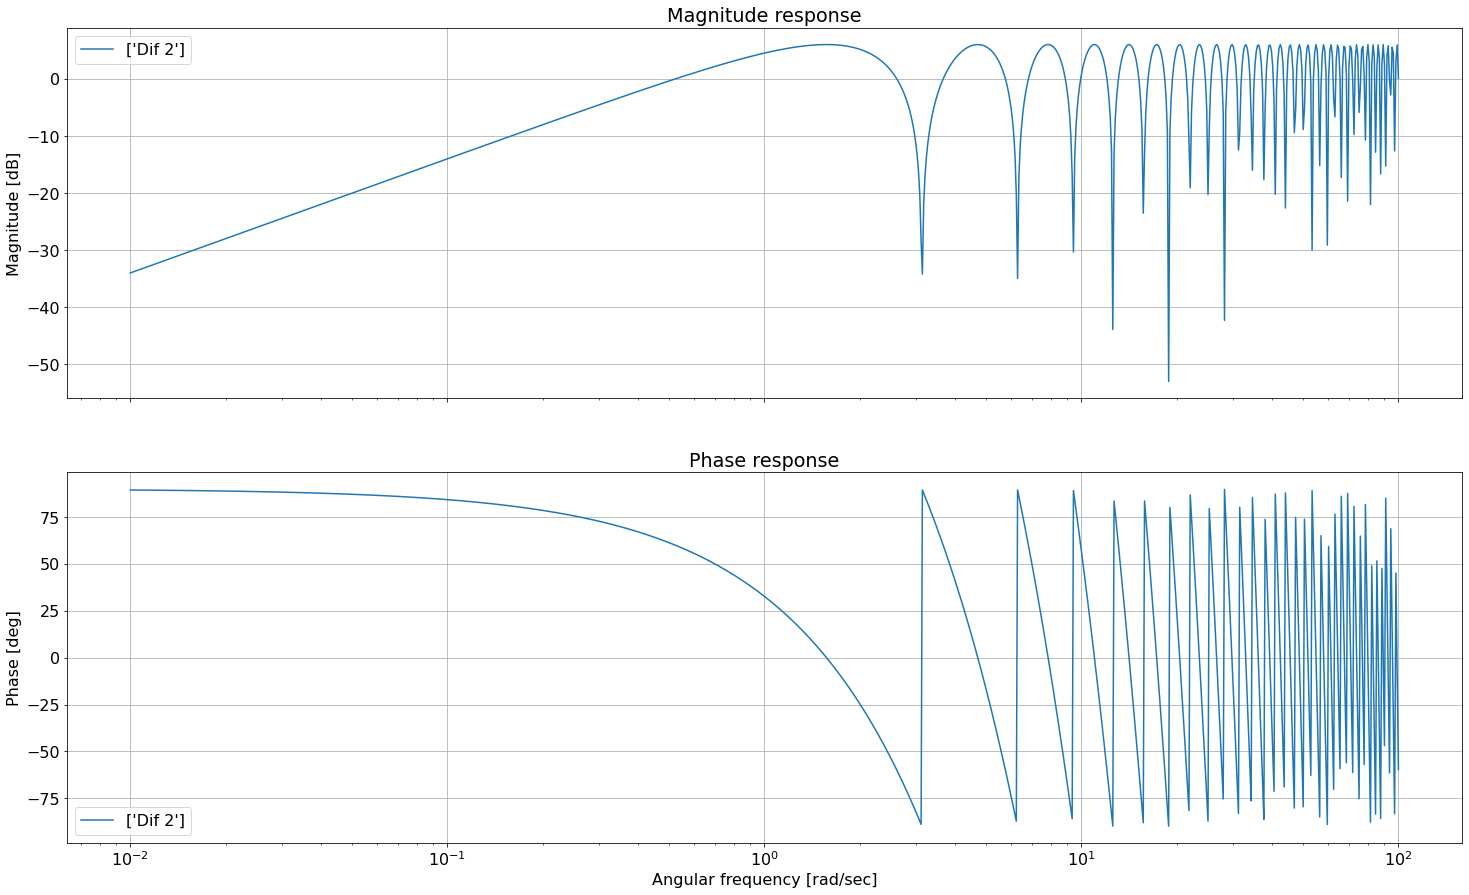

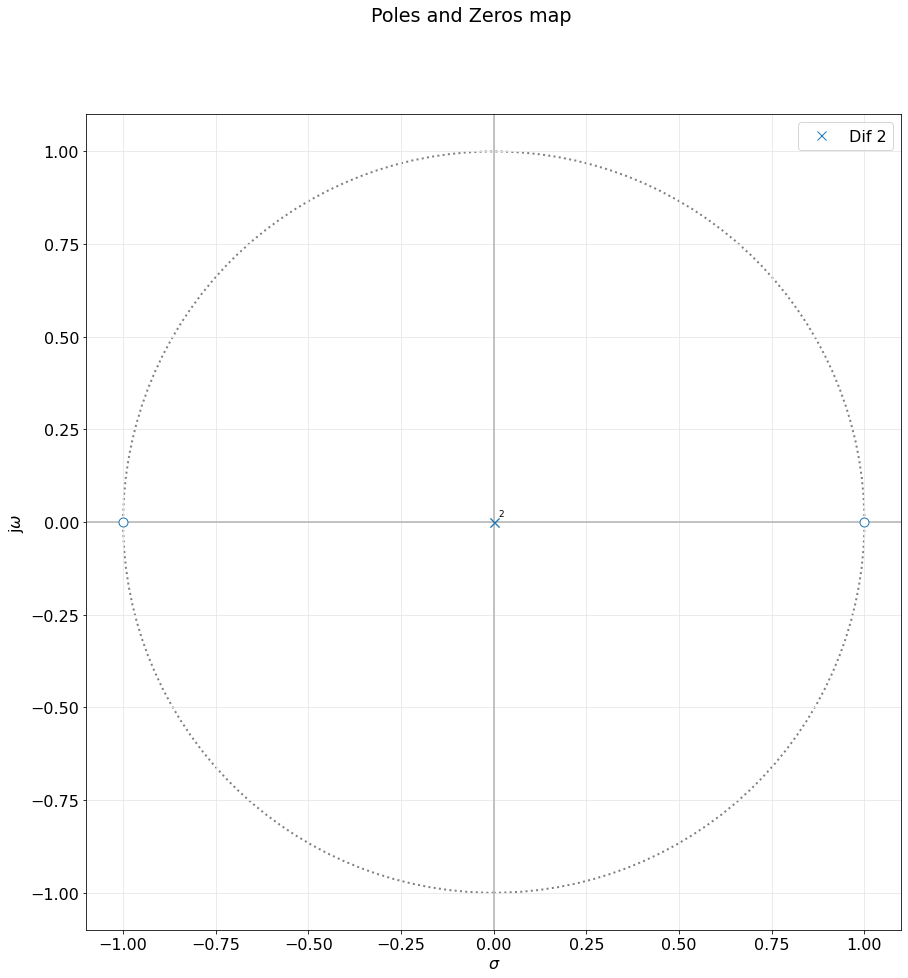

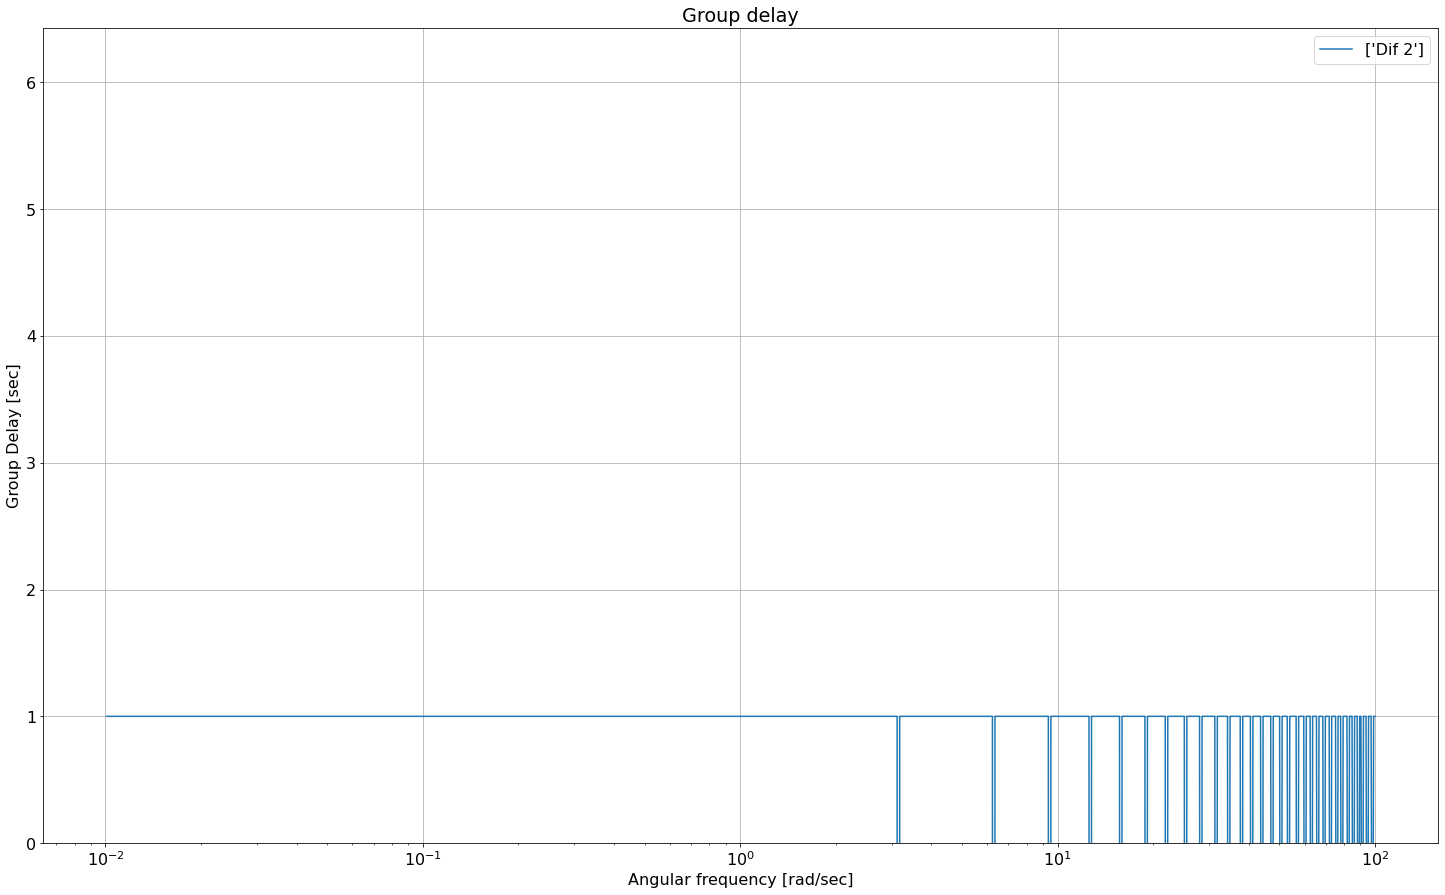

In [53]:
# Coeficientes en potencias decreciente
num_dif_2 = np.array([1, 0, -1])
den_dif_2 = np.array([1, 0, 0])

# Módulo y fase
sos_dif_2 = sig.TransferFunction(num_dif_2, den_dif_2, dt = 1)

all_sos = [sos_dif_2]
analyze_sys(all_sos, sys_name=['Dif 2'])

## Punto D

![Consigna](EJ4/Consignas/ConsignaD.png "Consigna")

#### Integrador con pérdidas
$H(z) = \frac{Y(z)}{X(z)}  =  (1 - c_1.Z^{-N}).\frac{b_0 + z^{-1}.b_1 + z^{-2}.b_2}{1/a_0 - z^{-1}.a_1 - z^{-2}.a_2 }$

$a_0 = 1, a_1 = 1- \alpha, b_0 = \alpha, \alpha = 0.9$

$H(z) = \frac{Y(z)}{X(z)} = \frac{\alpha}{1 - z^{-1}.(1-\alpha)} = \frac{0.9}{1 - z^{-1}.(0.1)}$

$H(z) = \frac{0.9}{1 - z^{-1}.(0.1)} . \frac{z}{z} = \frac{0.9.z}{z-0.1}$den_int_1



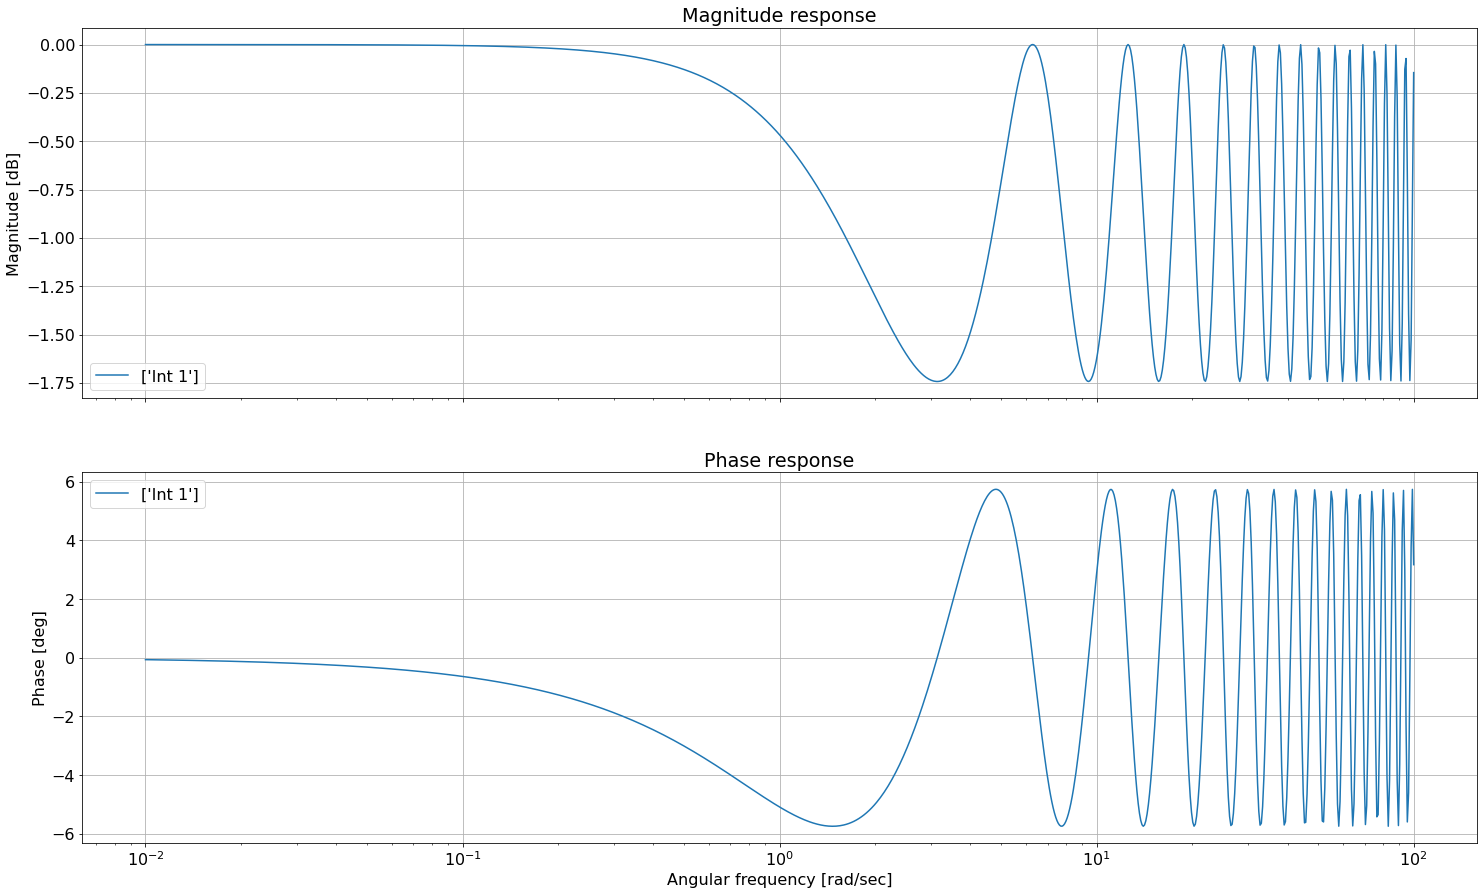

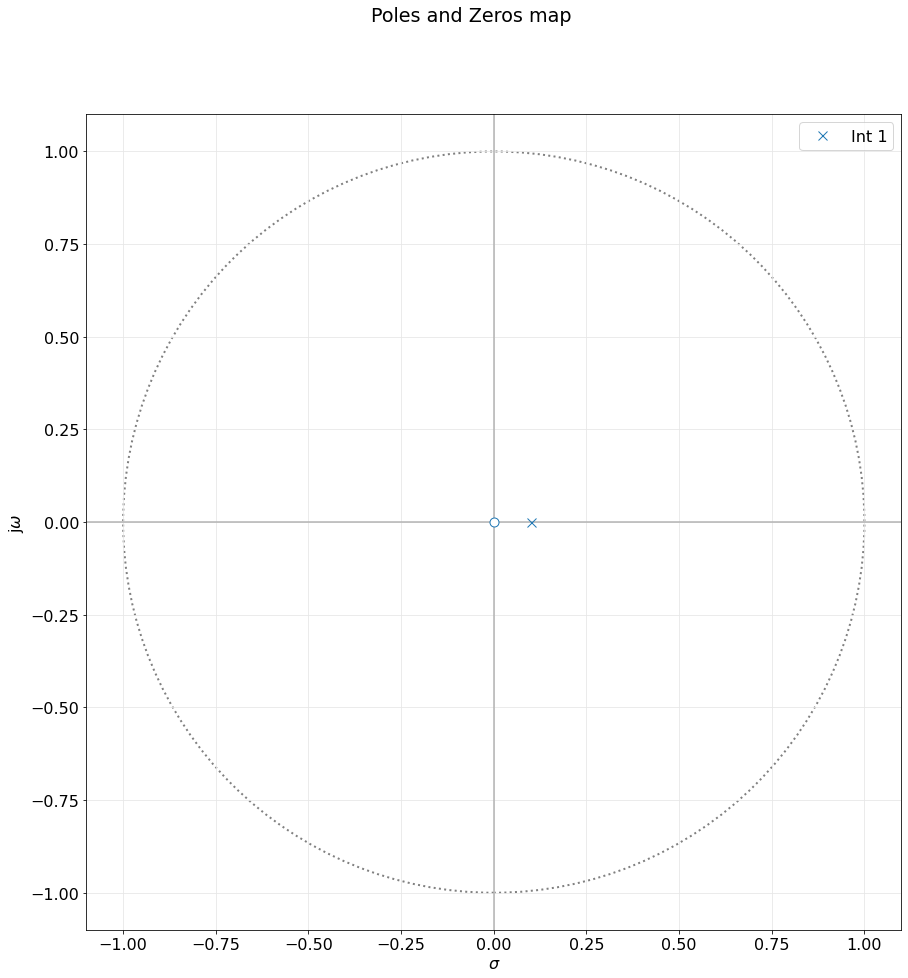

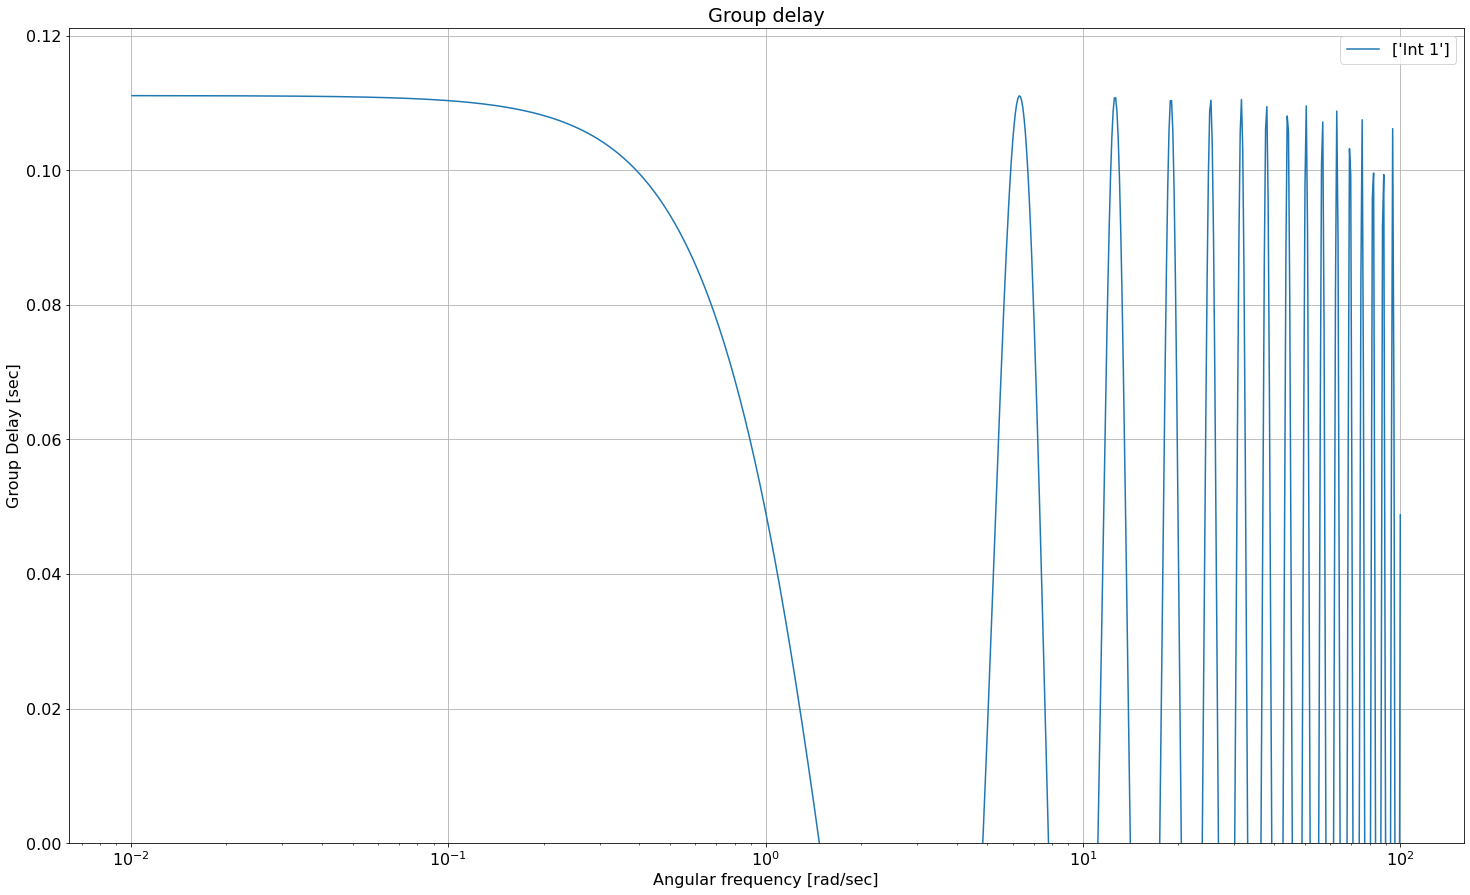

In [59]:
# Coeficientes en potencias decreciente
num_int_1 = np.array([0.9, 0])
den_int_1 = np.array([1, -0.1])

# Módulo y fase
sos_int_1 = sig.TransferFunction(num_int_1, den_int_1, dt = 1)

all_sos = [sos_int_1]
analyze_sys(all_sos, sys_name=['Int 1'])

## Punto E

![Consigna](EJ4/Consignas/ConsignaE.png "Consigna")

#### Elimina continua
$H(z) = \frac{Y(z)}{X(z)}  =  (1 - c_1.Z^{-N}).\frac{b_0 + z^{-1}.b_1 + z^{-2}.b_2}{1/a_0 - z^{-1}.a_1 - z^{-2}.a_2 }$

$a_0 = 1, a_1 = \alpha, b_0 = 1, b_1 = -1, \alpha = 0.9$

$H(z) = \frac{Y(z)}{X(z)} = \frac{1 - z^{-1}}{1 - z^{-1}.\alpha} = \frac{1- z^{-1}}{1 - z^{-1}.0.9}$

$H(z) = \frac{1 - z^{-1}}{1 - z^{-1}.0.9} . \frac{z}{z} = \frac{z - 1}{z-0.9}$



#### $\alpha$ para atenuación deseada
$H(jw) = \frac{j\omega - 1}{j\omega - \alpha}$

$|H(jw)| = \sqrt{\frac{\omega^{2} + 1}{\omega^{2} + \alpha^{2}}}$

$|H(0.1.\pi)|= 0.707.|H(\pi)|$

$\sqrt{\frac{(0.1.\pi)^{2} + 1}{(0.1.\pi)^{2} + \alpha^{2}}} = 0.707.\sqrt{\frac{\pi^{2} + 1}{\pi^{2} + \alpha^{2}}}$

$\frac{(0.1.\pi)^{2} + 1}{(0.1.\pi)^{2} + \alpha^{2}} = 0.5.\frac{\pi^{2} + 1}{\pi^{2} + \alpha^{2}}$

$((0.1.\pi)^{2} + 1) . (\pi^{2} + \alpha^{2}) = 0.5.(\pi^{2} + 1) . ((0.1.\pi)^{2} + \alpha^{2})$

$(\pi^{2} + \alpha^{2}) = 2.735.((0.1.\pi)^{2} + \alpha^{2})$

$(\pi^{2} + \alpha^{2}) = 0.27 + 2.735.\alpha^{2}$

$1.735.\alpha^{2} = \pi^{2} - 0.27 = 9.59$

$\alpha = 2.352$

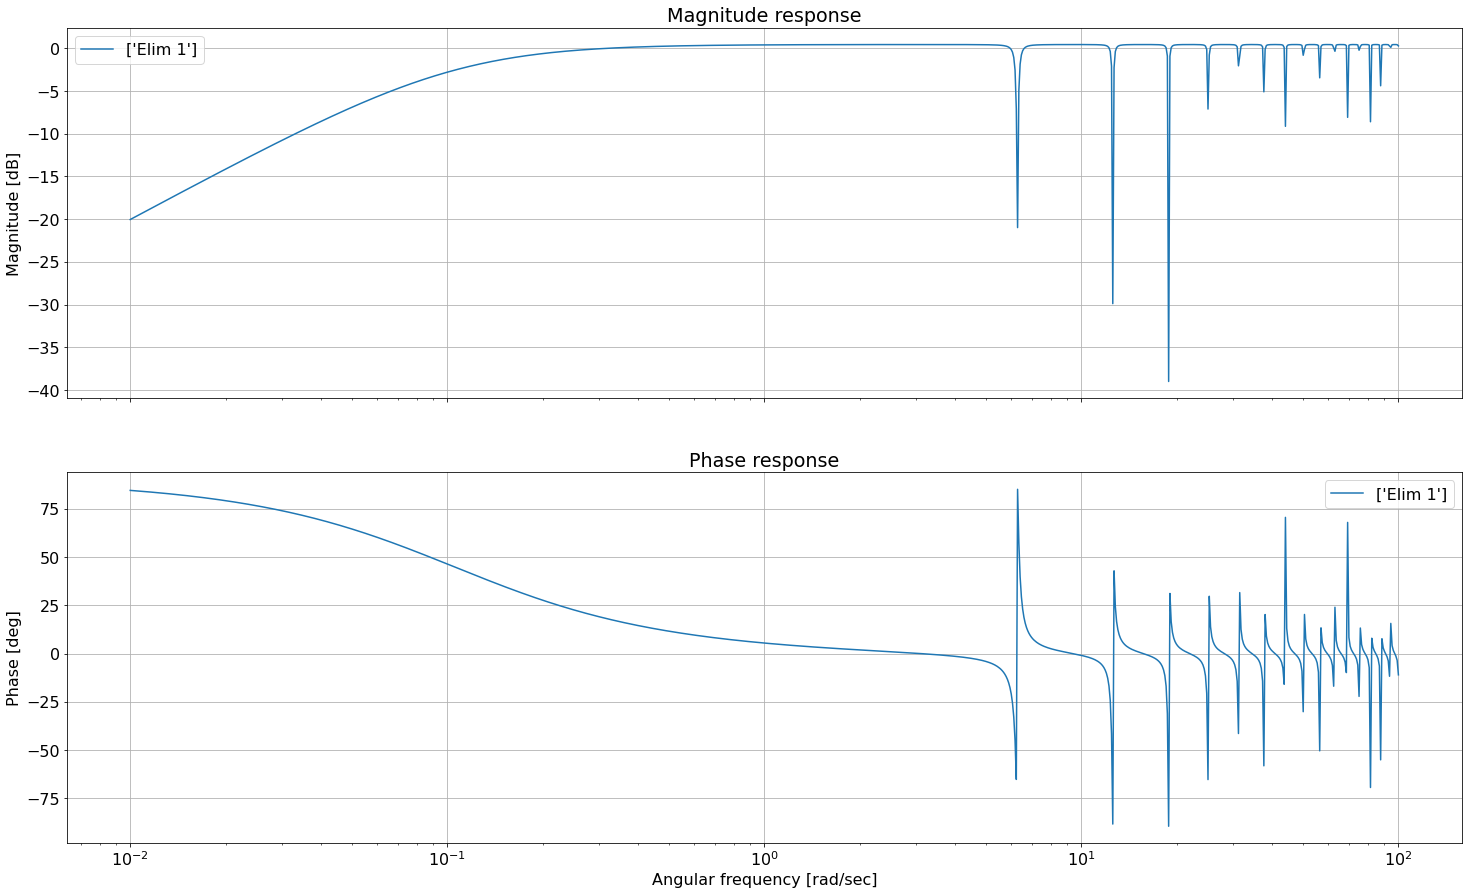

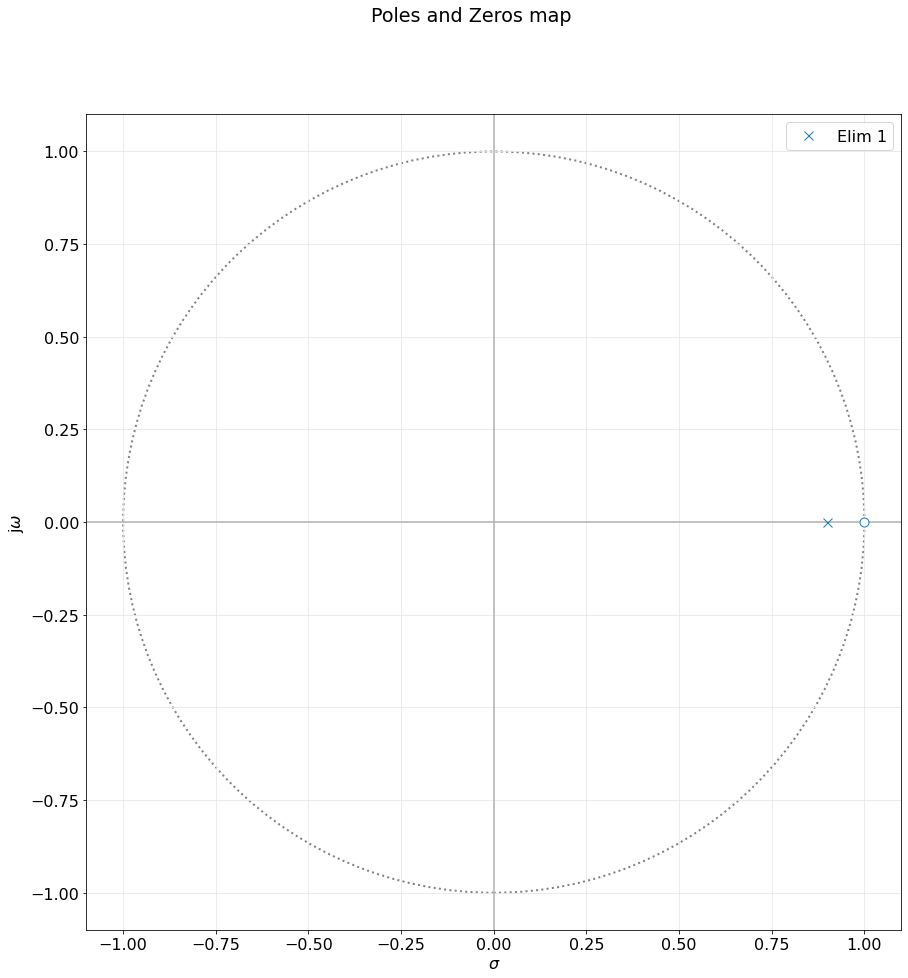

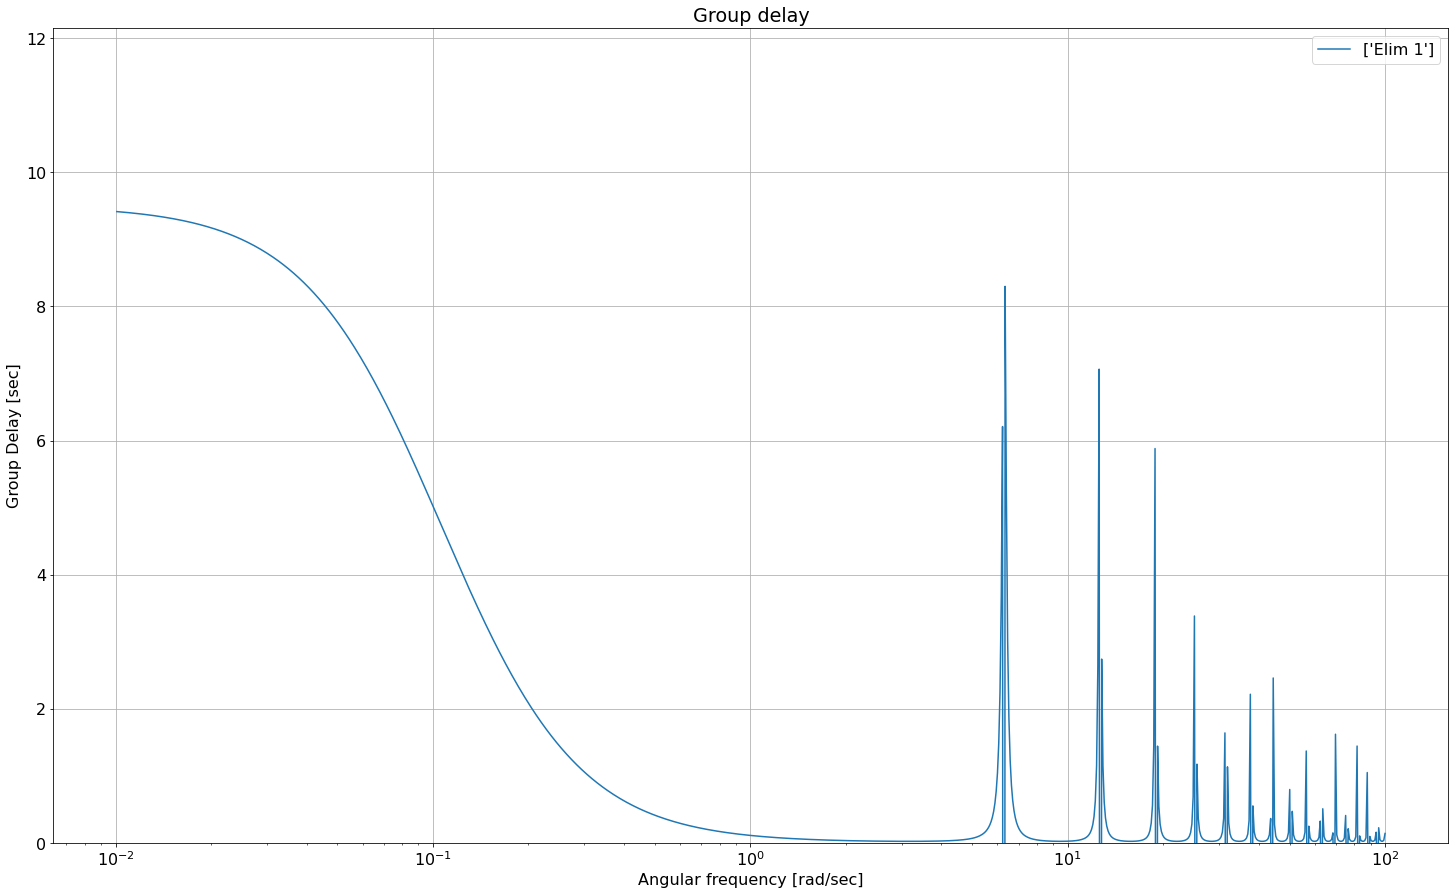

In [68]:
# Coeficientes en potencias decreciente
num_elim_1 = np.array([1, -1])
den_elim_1 = np.array([1, -0.9])

# Módulo y fase
sos_elim_1 = sig.TransferFunction(num_elim_1, den_elim_1, dt = 1)

all_sos = [sos_elim_1]
analyze_sys(all_sos, sys_name=['Elim 1'])

## Punto F

![Consigna](EJ4/Consignas/ConsignaF1.png "Consigna")

![Consigna](EJ4/Consignas/ConsignaF2.png "Consigna")

#### Ecualizador de fase
$H(z) = \frac{Y(z)}{X(z)}  =  (1 - c_1.Z^{-N}).\frac{b_0 + z^{-1}.b_1 + z^{-2}.b_2}{1/a_0 - z^{-1}.a_1 - z^{-2}.a_2 }$

$a_0 = 1, a_1 = -R, b_0 = R, b_1 = 1, R = \frac{-D}{D+2}$

$H(z) = \frac{Y(z)}{X(z)} = \frac{R + z^{-1}}{1 - z^{-1}.R}$

$H(z) = \frac{R + z^{-1}}{1 - z^{-1}.R} . \frac{z}{z} = \frac{R.z - 1}{z-R}$



D:\Anaconda\lib\site-packages\scipy\signal\filter_design.py:1631: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


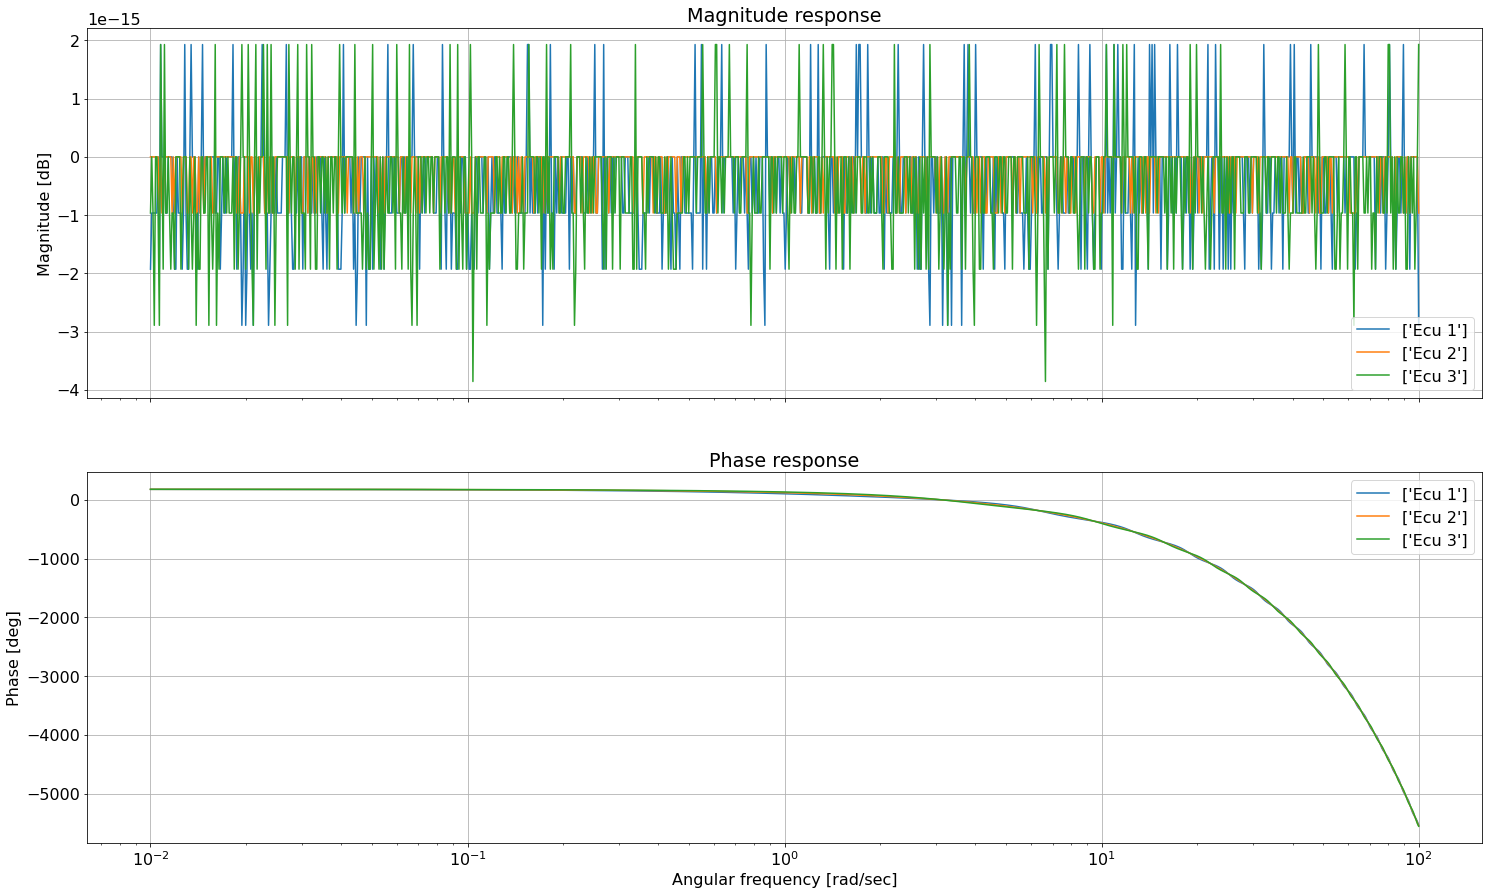

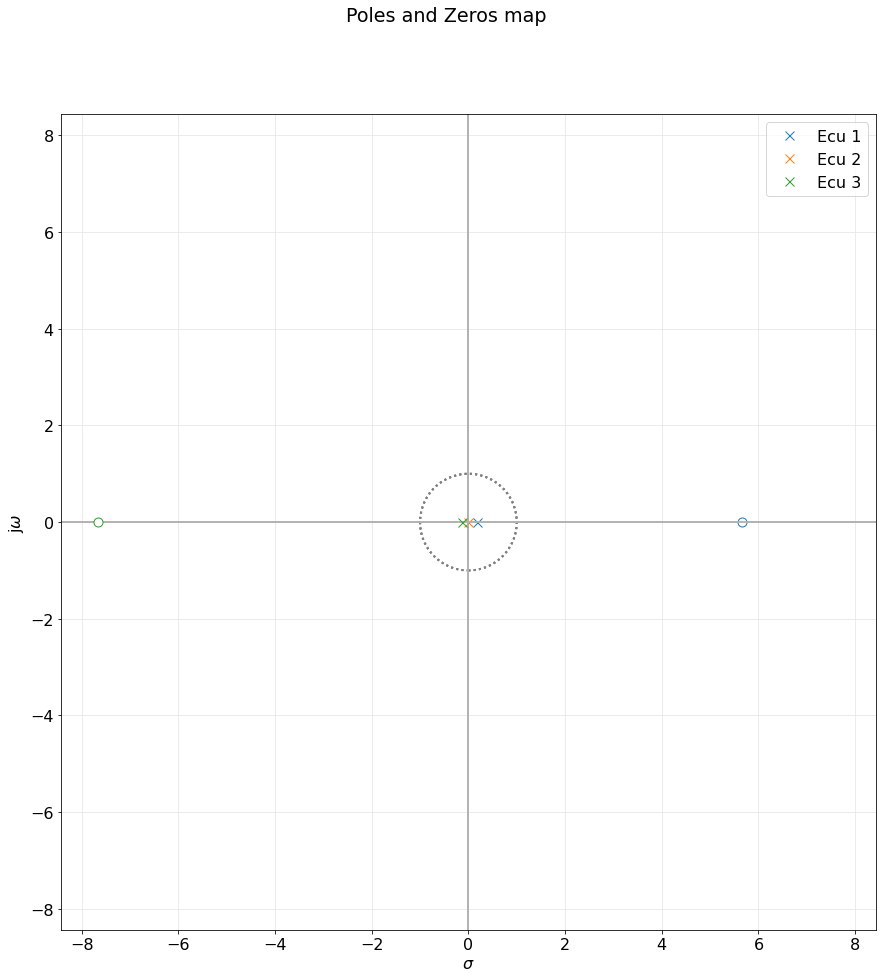

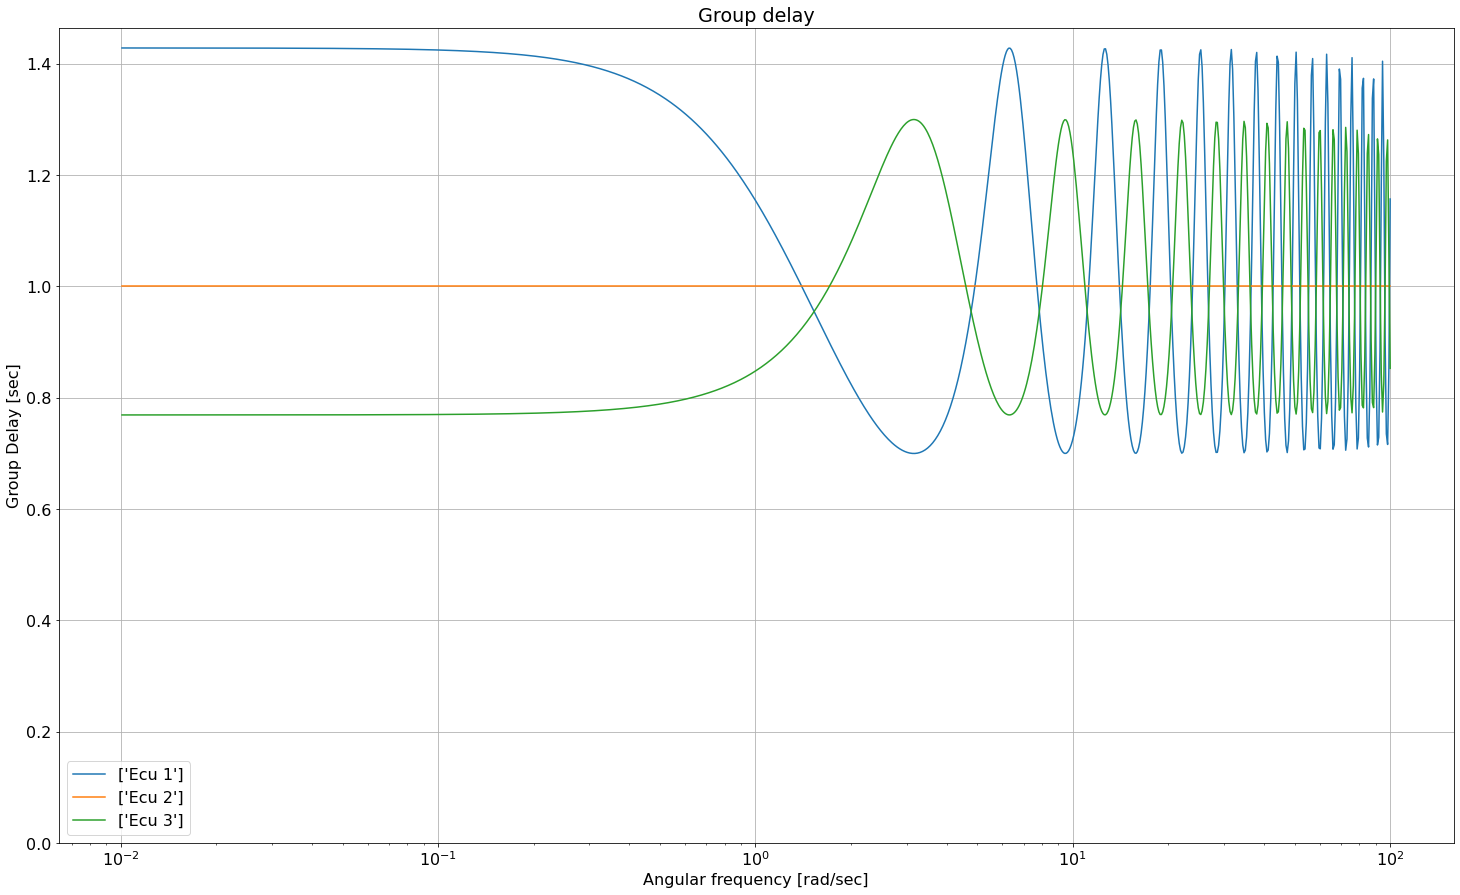

In [73]:
# Coeficientes en potencias decreciente
D1 = -0.3
D2 = 0
D3 = 0.3
R = [-D1/(D1+2), -D2/(D2+2), -D3/(D3+2)]
num_ecu_1 = np.array([R[0], -1])
den_ecu_1 = np.array([1, -R[0]])

num_ecu_2 = np.array([R[1], -1])
den_ecu_2 = np.array([1, -R[1]])

num_ecu_3 = np.array([R[2], -1])
den_ecu_3 = np.array([1, -R[2]])

# Módulo y fase
sos_ecu_1 = sig.TransferFunction(num_ecu_1, den_ecu_1, dt = 1)
sos_ecu_2 = sig.TransferFunction(num_ecu_2, den_ecu_2, dt = 1)
sos_ecu_3 = sig.TransferFunction(num_ecu_3, den_ecu_3, dt = 1)

all_sos = [sos_ecu_1, sos_ecu_2, sos_ecu_3]
analyze_sys(all_sos, sys_name=['Ecu 1', 'Ecu 2', 'Ecu 3'])

# Ejercicio 5

Pending

# Ejercicio 6

Pending

# Ejercicio 7

Obtenga la expresión $H(z)$ de los siguientes sistemas. Indique de qué tipo de filtros se trata.

![consigna](EJ7/img/ej7_consigna.JPG)


### a)

$Y(z) = X(z) . a_0 + X(z) . z^{-1} . a_1 + X(z) . z^{-2} . a_2 - Y(z) . z^{-1} . b_1 - Y(z) . z^{-2} . b_2$

$Y(z) . (z^{-2} . b_2 + z^{-1} . b_1 + 1) = X(z) . (z^{-2} . a_2 + z^{-1} . a_1 + a_0)$

$T(z) = \frac{Y(z)}{X(z)} = \frac{z^{-2} . a_2 + z^{-1} . a_1 + a_0}{z^{-2} . b_2 + z^{-1} . b_1 + 1}$

Este es un filtro IIR ya que depende tanto de valores de la entrada (actuales y previos) como de valores previos de la salida.

### b)

$Y(z) = X_1(z) . a_0 + X_1(z) . z^{-1} . a_1 + X_1(z) . z^{-2} . a_2$

Donde:

$X_1(z) = X(z) - X_1(z) . z^{-1} . b_1 - X_1(z) . z^{-2}  . b_2$

$X_1(z) . (z^{-2}  . b_2 + z^{-1} . b_1 + 1) = X(z)$

$X_1(z) = X(z) . \frac{1}{z^{-2}  . b_2 + z^{-1} . b_1 + 1}$

Entonces:

$Y(z) =  X_1(z) . (z^{-2} . a_2 + z^{-1} . a_1 + a_0)$

$Y(z) =  X(z) . \frac{1}{z^{-2}  . b_2 + z^{-1} . b_1 + 1} . (z^{-2} . a_2 + z^{-1} . a_1 + a_0)$

$H(z) = \frac{Y(z)}{X(z)} = \frac{z^{-2} . a_2 + z^{-1} . a_1 + a_0}{z^{-2}  . b_2 + z^{-1} . b_1 + 1}$

Este es un filtro FIR ya que depende únicamente de valores actuales y previos de la entrada.


### c)

$X_1(z) = z^{-1} . (X(z) . a_2 - Y(z) . b_2) = X(z) . z^{-1} . a_2 - Y(z) . z^{-1} . b_2$

$X_2(z) = z^{-1} . (X_1(z) + X(z) . a_1 - Y(z) . b_1) = X_1(z) . z^{-1} + X(z) . z^{-1} . a_1 - Y(z) . z^{-1} . b_1$

$X_2(z) = X(z) . z^{-2} . a_2 - Y(z) . z^{-2} . b_2 + X(z) . z^{-1} . a_1 - Y(z) . z^{-1} . b_1$

Finalmente:

$Y(z) = X(z) . a_0 + X_2(z) = X(z) . a_0 + X(z) . z^{-2} . a_2 - Y(z) . z^{-2} . b_2 + X(z) . z^{-1} . a_1 - Y(z) . z^{-1} . b_1$

Nuevamente la transferencia queda como:

$H(z) = \frac{Y(z)}{X(z)} = \frac{z^{-2} . a_2 + z^{-1} . a_1 + a_0}{z^{-2}  . b_2 + z^{-1} . b_1 + 1}$

Este filtro también es de tipo IIR ya que depende de valores actuales y previos de la entrada y valores previos de la salida.